In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
# substitute for your own DiffSci path
os.chdir('c:\\Users\\bepsc\\OneDrive\\Documentos\\GitHub\\DiffSci')

In [ ]:

import math
import diffsci.data
import diffsci.models
from scipy.stats import wasserstein_distance, entropy
import pathlib
import re
from scipy import integrate
import itertools

In [4]:
# Define Gaussian mixture dataset
points2 = torch.tensor([[-0.6, -0.6],[0.1, 0.1]])
weights2 = torch.tensor([0.1,0.9])
scale2 = torch.tensor([0.05,0.2])
nsamples2 = 100000
gaussian_dataset2 = diffsci.data.MixtureOfGaussiansDataset(num_samples=nsamples2, means=points2, weights=weights2, scale=scale2) 
gaussian_samples2 = gaussian_dataset2.sample()

# compute mean and std
mean = gaussian_samples2.mean()
std = gaussian_samples2.std()
print(f'Mean: {mean}')
print(f'std: {std}')

Mean: 0.02993740513920784
std: 0.2834908366203308


Text(0.5, 1.0, '2D Gaussian mixture pdf')

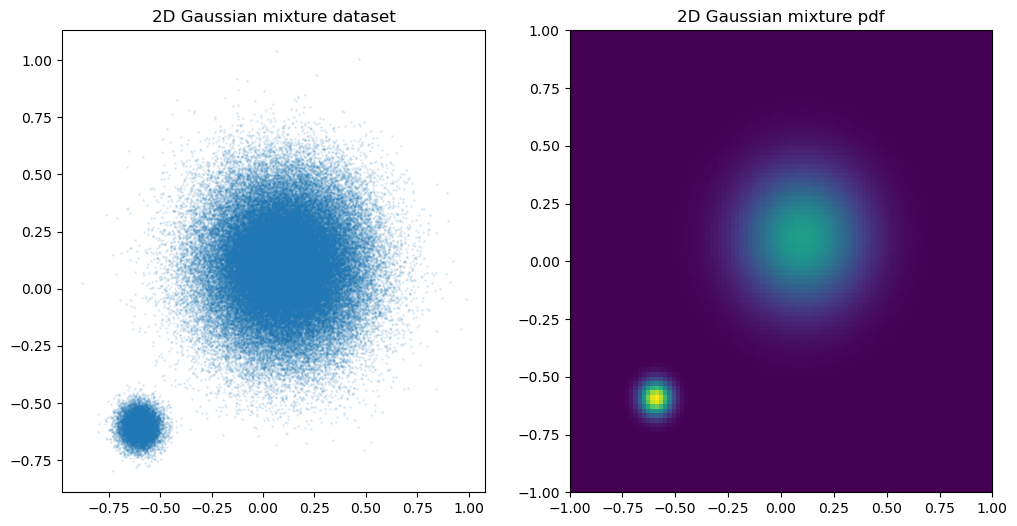

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot a 2D colormap of the generated samples
axs[0].scatter(gaussian_samples2[:, 0], gaussian_samples2[:, 1], s=1, alpha=0.1)
axs[0].set_title("2D Gaussian mixture dataset")

# Generate 2D grid of points
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x, y)
X = np.stack([xx.ravel(), yy.ravel()], axis=-1)  # shape: (10000, 2)
X = torch.tensor(X, dtype=torch.float32)  # shape: (10000, 2)

sigma = torch.zeros_like(X[..., 0])
Z = gaussian_dataset2.prob(X,sigma)
Z = Z.reshape(xx.shape)  # shape: (100, 100)
axs[1].imshow(Z, extent=(-1, 1, -1, 1), origin='lower', aspect='auto')
axs[1].set_title("2D Gaussian mixture pdf")

Text(0.5, 1.0, 'Score function vector field')

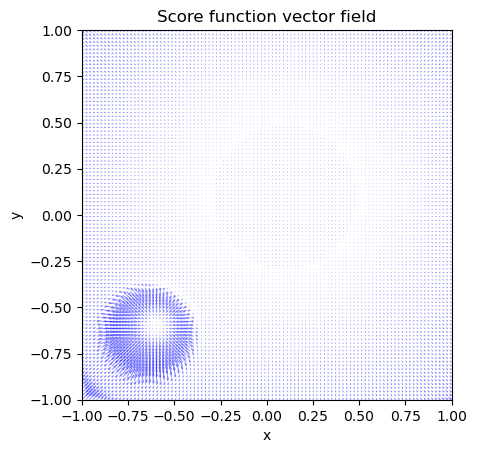

In [6]:
# plot the score function vector field
score2 = gaussian_dataset2.gradlogprob(X, sigma)
plt.quiver(X[:, 0], X[:, 1], score2[:, 0], score2[:, 1], color='b', alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Score function vector field")

In [7]:
# define diffusion prior
def prior_pdf(x, sigma):
    x_norm2 = torch.sum(x**2, dim=-1)
    expterm = -0.5 * x_norm2 / sigma**2
    normalizer = 1/(np.sqrt(2*math.pi)*sigma)
    return normalizer * torch.exp(expterm)

Text(0.5, 1.0, 'Approx pdf')

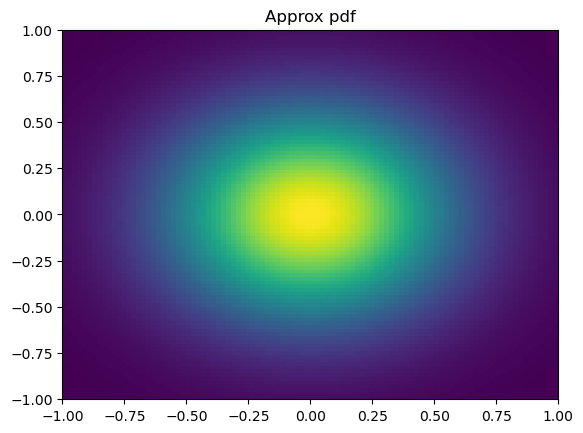

In [8]:
sigma = torch.ones_like(X[..., 0]) * 0.4
Z = prior_pdf(X,sigma)
Z = Z.reshape(xx.shape)  # shape: (100, 100)
plt.imshow(Z, extent=(-1, 1, -1, 1), origin='lower', aspect='auto')
plt.title("Approx pdf")

Define all functions

In [9]:
# define diffusion prior
def prior_pdf(x, sigma):
    x_norm2 = torch.sum(x**2, dim=1)
    n = x.shape[1]
    expterm = -0.5 * x_norm2 / sigma**2
    normalizer = (2*math.pi*sigma**2)**(-n/2)
    return normalizer * torch.exp(expterm)

# Variable formatting
def formatted(variable):
    if variable < 1e-3:
        formatted_variable = f'{variable:.2e}'
        formatted_variable = re.sub(r'e([-+]?)(\d+)', r' \\times 10^{\1\2}', formatted_variable)
    else:
        formatted_variable = f'{variable:.4f}'
    return formatted_variable

def analytical_initial_entropy(dataset, initial_time, scheduler, xlim=3, ngrid=100, plot=False, return_pdf=False, 
                               process='edm', fontsize=14, inverseH=False, ndim=1):
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(initial_time))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(initial_time))
    s = torch.tensor(sigma * scale)

    # Construct nD grid using uniform spacing
    axes = [torch.linspace(-xlim, xlim, ngrid) for _ in range(ndim)]
    mesh = torch.meshgrid(*axes, indexing='ij')
    x_grid = torch.stack([m.reshape(-1) for m in mesh], dim=1)  # shape: [ngrid**ndim, ndim]

    # Evaluate densities
    p = prior_pdf(x_grid, s)
    q = dataset.prob(x_grid, sigma.unsqueeze(-1), scale.unsqueeze(-1))

    # Compute differential volume element from axis spacing
    dxs = [axes[i][1] - axes[i][0] for i in range(ndim)]
    dV = torch.prod(torch.stack(dxs))

    # Compute relative entropy KL(p || q) or KL(q || p)
    epsilon = 1e-15
    p_ = torch.clip(p, epsilon, None)
    q_ = torch.clip(q, epsilon, None)
    if inverseH:
        kl_element = q_ * torch.log(q_ / p_)
    else:
        kl_element = p_ * torch.log(p_ / q_)
    entropy = torch.sum(kl_element) * dV
    # Check normalization
    # print(torch.sum(p)*dV, torch.sum(q)*dV)
    entropy = entropy.item()

    # Plotting (ndim = 1 or 2)
    if plot:
        formatted_entropy = formatted(entropy)
        textstr = f'$H_{{init}} = {formatted_entropy}$' if not inverseH else f'$H(p|\\tilde{{p}}) = {formatted_entropy}$'

        if ndim == 1:
            x = x_grid[:, 0]
            plt.plot(x, p, label='approx prior pdf')
            plt.plot(x, q, label='exact prior pdf')
            plt.legend(fontsize=fontsize)
            plt.title(f'Distributions at $t = {initial_time:.2f}$ ({process.upper()})', fontsize=fontsize + 2)
            plt.gca().text(0.025, 0.75, textstr, transform=plt.gca().transAxes, fontsize=fontsize,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
            plt.show()

        elif ndim == 2:
            X, Y = mesh
            P_grid = p.reshape(ngrid, ngrid)
            Q_grid = q.reshape(ngrid, ngrid)

            fig, axs = plt.subplots(1, 2, figsize=(12, 5))
            im0 = axs[0].contourf(X, Y, P_grid, levels=100, cmap='Blues')
            axs[0].set_title('Approximate prior PDF', fontsize=fontsize)
            axs[0].set_xlabel(r'$x_1$', fontsize=fontsize)
            axs[0].set_ylabel(r'$x_2$', fontsize=fontsize)
            fig.colorbar(im0, ax=axs[0])

            im1 = axs[1].contourf(X, Y, Q_grid, levels=100, cmap='Reds')
            axs[1].set_title('Exact prior PDF', fontsize=fontsize)
            axs[1].set_xlabel(r'$x_1$', fontsize=fontsize)
            axs[1].set_ylabel(r'$x_2$', fontsize=fontsize)
            fig.colorbar(im1, ax=axs[1])

            axs[1].text(0.025, 0.95, textstr, transform=axs[1].transAxes, fontsize=fontsize,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
            plt.suptitle(f'Distributions at $t = {initial_time:.2f}$ ({process.upper()})', fontsize=fontsize + 2)
            plt.tight_layout()
            plt.show()

        else:
            raise NotImplementedError("Plotting is only implemented for ndim = 1 or 2")

    if return_pdf:
        return entropy, p, q, x_grid
    else:
        return entropy


In [10]:
def approx_entropy(samples1, samples2, samples_ref, epsilon=1e-12, nbins=100, mean=True, inverseH=False):
    samples1 = samples1.detach().cpu().numpy()
    samples2 = samples2.detach().cpu().numpy()
    samples_ref = samples_ref.detach().cpu().numpy()

    assert samples1.shape[1] == samples2.shape[1] == samples_ref.shape[1], "Samples must have same dimension"

    ndim = samples1.shape[1]

    entropies1 = []
    entropies2 = []

    for nb in range(nbins - 20, nbins):
        if nb % 4 == 0:
            continue

        # Compute bin edges for each dimension
        all_samples = np.vstack([samples1, samples2, samples_ref])
        mins = np.min(all_samples, axis=0)
        maxs = np.max(all_samples, axis=0)
        bins = [np.linspace(mins[i], maxs[i], nb) for i in range(ndim)]

        # Compute histograms
        dist = []
        for samples in [samples1, samples2, samples_ref]:
            hist, _ = np.histogramdd(samples, bins=bins, density=True)
            hist = hist.flatten()
            dist.append(hist + epsilon)

        if inverseH:
            entropy1 = entropy(dist[2], dist[0])
            entropy2 = entropy(dist[2], dist[1])
        else:
            entropy1 = entropy(dist[0], dist[2])
            entropy2 = entropy(dist[1], dist[2])

        entropies1.append(entropy1)
        entropies2.append(entropy2)

    if mean:
        entropy1 = np.mean(entropies1)
        entropy2 = np.mean(entropies2)
    else:
        entropy1 = np.min(entropies1)
        entropy2 = np.min(entropies2)

    return entropy1, entropy2


def approx_entropy1(samples, samples_ref, epsilon=1e-12, nbins=100):
    samples = samples.detach().cpu().numpy()
    samples_ref = samples_ref.detach().cpu().numpy()

    assert samples.shape[1] == samples_ref.shape[1], "Samples must have same dimension"
    ndim = samples.shape[1]

    # Compute bin edges
    all_samples = np.vstack([samples, samples_ref])
    mins = np.min(all_samples, axis=0)
    maxs = np.max(all_samples, axis=0)
    bins = [np.linspace(mins[i], maxs[i], nbins) for i in range(ndim)]

    # Compute histograms
    dist = []
    for s in [samples, samples_ref]:
        hist, _ = np.histogramdd(s, bins=bins, density=True)
        hist = hist.flatten()
        dist.append(hist + epsilon)

    return entropy(dist[0], dist[1])

In [11]:
def path_from_datatype(datatype, figure=False):
    if datatype == 'gaussian':
        path = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/2d_gaussian')
    elif datatype == 'gaussian2':
        path = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/2d_gaussian2')
    else:
        raise ValueError('Invalid datatype')
    if figure:
        path = path / 'figures'
    return path

In [12]:
def generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype,
                     interval=None,
                     sample_type='ode',
                     noisescheduler=diffsci.models.EDMScheduler(sigma_max=10),
                     scheduler_type= 'edm',
                     module=None,
                     use_exact_prior=False,
                     return_history=True,
                     checkpoint=None,
                     save_samples=True,
                     interp_fn = None,
                     plot_coords=None,
                     nbins=30):
    print(f'NoiseScheduler: {noisescheduler}')
    # set noise scheduler
    noisescheduler._integrator = diffsci.models.EulerIntegrator()
    noisescheduler.langevin_const = gamma
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # obtain initial time from initial step
    time = noisescheduler.create_steps(nsteps+1)
    initial_time_ = time[initial_step]
    initial_time = initial_time_.item() 

    # generate prior distribution
    dataset.num_samples = nsamples
    samples = dataset.sample()
    sigma = noisescheduler.scheduler_fns.noise_fn(initial_time_)
    scale = noisescheduler.scheduler_fns.scaling_fn(initial_time_)
    prior = torch.randn_like(samples) * sigma * scale
    prior_ = prior.squeeze(-1)
    exact_prior = noisescheduler.apply_noise(samples, nsteps, initial_step)
    exact_prior_ = exact_prior.squeeze(-1)

    # Compute initial relative entropy from samples (KL(prior || exact_prior))
    sample_initial_entropy, _ = approx_entropy(prior, exact_prior, exact_prior, nbins=nbins)
    print(f'Sample-based initial entropy = {sample_initial_entropy:.5f}')


    # plot prior distributions
    ndim = prior.shape[1]
    if plot_coords is None:
        plot_coords = list(range(ndim))  # plot all dimensions
    nbins = 100
    xlim = 5*sigma
    exact_initial_entropy = analytical_initial_entropy(
        dataset, initial_time, scheduler=noisescheduler, plot = True, xlim=xlim, ndim=ndim)
    print(f'Exact initial entropy = {exact_initial_entropy:.5f}')

    approx_densities = []
    exact_densities = []
    xs = []

    for coord in plot_coords:
        # Generate 1D grid in R^n where only the `coord`-th dimension varies
        x = torch.linspace(-xlim, xlim, nbins)
        x_full = torch.zeros(nbins, ndim)
        x_full[:, coord] = x

        sigma = noisescheduler.scheduler_fns.noise_fn(initial_time_)
        scale = noisescheduler.scheduler_fns.scaling_fn(initial_time_)
        s = torch.tensor(sigma * scale)

        # Evaluate both distributions along this 1D axis in R^n
        p = prior_pdf(x_full, s)
        q = dataset.prob(x_full, sigma.unsqueeze(-1), scale.unsqueeze(-1))

        approx_densities.append(p.detach().cpu().numpy())
        exact_densities.append(q.detach().cpu().numpy())
        xs.append(x.detach().cpu().numpy())


    ncols = len(plot_coords)
    fig, axes = plt.subplots(2, len(plot_coords), figsize=(5 * len(plot_coords), 8))
    for i, coord in enumerate(plot_coords):
        # Project samples onto the same slice used for theoretical pdf: only coord varies, others zero
        x_slice = torch.zeros(prior.shape[1], device=prior.device)
        x_slice[coord] = 1.0  # direction vector along coord axis
        prior_proj = (prior @ x_slice).cpu().numpy()
        exact_proj = (exact_prior @ x_slice).cpu().numpy()


        # First row: histograms of actual samples
        axes[0, i].hist(prior_proj, bins=nbins, density=True, alpha=0.5, label='indep prior', color='brown')
        axes[0, i].hist(exact_proj, bins=nbins, density=True, alpha=0.5, label='exact prior', color='green')
        axes[0, i].set_title(f'Samples at $T = {initial_time:.2f}$ (coord {coord})')
        axes[0, i].legend()
        axes[0, i].set_xlim([-xlim, xlim])

        # Second row: analytic slices along coordinate axis
        x = xs[i]
        approx_dens = approx_densities[i]
        exact_dens = exact_densities[i]
        axes[1, i].plot(x, exact_dens, label='exact prior pdf')
        axes[1, i].plot(x, approx_dens, label='indep prior pdf')
        axes[1, i].set_title(f'Densities at $T = {initial_time:.2f}$ (coord {coord})')
        axes[1, i].legend()
        textstr = f'$H_{{init}} = {formatted(exact_initial_entropy)}$'
        axes[1, i].text(0.025, 0.95, textstr, transform=axes[1, i].transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # backward integration
    if use_exact_prior:
        prior = exact_prior
    
    if sample_type == 'ode':
        stochastic = False
        integrator = diffsci.models.EulerIntegrator()
    elif sample_type == 'sde':
        stochastic = True
        integrator = diffsci.models.EulerMaruyamaIntegrator()
    else:
        raise ValueError('Invalid sample_type')
    
    if module is not None:
        print('Sampling with learned scores, device: ', module.device)
        prior = prior.to(module.device)
        sample_history = module.propagate_partial_toward_sample(
             prior, initial_step=initial_step, nsteps=nsteps, record_history=True, integrator=integrator,
             analytical_score=dataset.gradlogprob, interp_fn=interp_fn)
        sample_history = sample_history.cpu()
    else:
        sample_history = noisescheduler.propagate_partial(
            prior, dataset.gradlogprob, nsteps, initial_step=initial_step, final_step=nsteps,
            record_history=True, stochastic=stochastic)
    
    # plot trajectory
    time = noisescheduler.create_steps(nsteps+1)
    trunc_time = time[initial_step:]
    nplot = 300

    fig, axes = plt.subplots(1, len(plot_coords), figsize=(5 * len(plot_coords), 5))
    for i, coord in enumerate(plot_coords):
        ax = axes[i] if len(plot_coords) > 1 else axes
        for j in range(min(nplot, sample_history.shape[1])):
            trajectory = sample_history[:, j, coord].cpu()
            ax.plot(trunc_time, trajectory, color='black', alpha=0.1)
        ax.set_title(f'Trajectory (coord {coord})')
        ax.set_xlabel("diffusion time")
        ax.set_ylabel("value")
        ax.set_ylim([-3, 3])

    plt.tight_layout()
    plt.suptitle(f'{sample_type.upper()} trajectories', fontsize=16, y=1.02)
    plt.show()

    if return_history:
        samples = sample_history.squeeze(-1)
    else:
        samples = sample_history[-1].squeeze(-1)

    # save data
    if save_samples:
        if module is not None:
            if checkpoint is None:
                raise ValueError('Checkpoint is required')
            path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
        else:
            path = path_from_datatype(datatype)
        path.mkdir(exist_ok=True)
        
        filename = f'nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}'
        if module is not None:
            filename = 'tr-' + filename
        else:
            filename = 'an-' + filename
        if use_exact_prior:
            filename = f'{sample_type}-exact_prior-' + filename
        else:
            filename = f'{sample_type}-indep_prior-' + filename
        if sample_type == 'sde':
            if interval is not None:
                filename += f'-g={gamma}-int={interval}'
            else:
                filename += f'-g={gamma}'
        if interp_fn is not None:
            filename += '-interp'
        
        if return_history:
            filename += '-his'            
        if scheduler_type == 'edm':
            filename += '-EDM'
        elif scheduler_type == 'vp':
            filename += '-VP'
        elif scheduler_type == 've':
            filename += '-VE'
        else:
            raise ValueError('Invalid scheduler_type')
        
        print(f'Saving samples to {path / filename}')
        torch.save(samples, path / filename)
    return samples

In [13]:
def plot_figure(samples_ode, samples_sde, data, nsamples, nsteps, gamma, initial_time, datatype,
                initial_entropy=0, bound=None, nbins=100,
                title='Approximate prior and analytic scores',
                figname='approx_prior-analytic',
                fontsize=14, savefig=True, alpha=0.1):

    if samples_ode.shape[1] != 2:
        raise ValueError(f"This version of plot_figure expects 2D data, but got shape {samples_ode.shape}")

    # compute entropy
    ode_entropy, sde_entropy = approx_entropy(samples_ode, samples_sde, data, nbins=nbins)

    # plot: 3 subplots for Data, ODE, and SDE
    fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharex=True, sharey=True)

    titles = ['True data', 'ODE samples', f'SDE samples ($\\gamma = {gamma:.1f}$)']
    datasets = [data, samples_ode, samples_sde]
    colors = ['#000000', '#1f77b4', '#ff7f0e']

    for ax, title_i, samples, color in zip(axes, titles, datasets, colors):
        ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=alpha, color=color)
        ax.set_title(title_i, fontsize=fontsize)
        ax.set_xlabel(r'$x_1$', fontsize=fontsize)
        ax.set_ylabel(r'$x_2$', fontsize=fontsize)

    # Add shared entropy box to last plot
    if initial_entropy != 0:
        formatted_initial_entropy = formatted(initial_entropy)
        textstr = f'Entropy values:\n$H_{{init}} = {formatted_initial_entropy}$ \n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$ \n ($n_{{bins}} = {nbins}$)'
    else:
        textstr = f'Entropy values:\n$H_{{ODE}} = {ode_entropy:.4f}$ \n$H_{{SDE}} = {sde_entropy:.4f}$ \n ($n_{{bins}} = {nbins}$)'
    if bound is not None:
        textstr += f'\n \n bound: {bound:.4f}'

    axes[2].text(0.025, 0.95, textstr, transform=axes[2].transAxes, fontsize=fontsize,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    fig.suptitle(title + f', $T = {initial_time:.2f}$', fontsize=fontsize+4)
    plt.tight_layout()

    # Save figure
    if savefig:
        path = path_from_datatype(datatype, figure=True)
        path.mkdir(exist_ok=True)
        figure_name = figname + f'-nsamples={nsamples:.0e}-nsteps={nsteps}-g={gamma}-T={initial_time:.2f}.png'
        fig.savefig(path / figure_name)

    return None


In [14]:
def compute_entropy_evolution(ode_history, sde_history, diffused_history, time,  mean=True, nbins=100,
                              inverseH=False):

    ode_entropies = []
    sde_entropies = []
    ode_wdistances = []
    sde_wdistances = []
    nsteps = time.shape[0]
    for i in range(nsteps):
        ode_entropy, sde_entropy = approx_entropy(ode_history[i], sde_history[i], diffused_history[i],
                                                  nbins=nbins, mean=mean, inverseH=inverseH)
        ode_entropies.append(ode_entropy)
        sde_entropies.append(sde_entropy)
    return ode_entropies, sde_entropies

def plot_entropy_evolution(ode_entropies, sde_entropies, time, nsamples, gamma, initial_time, nsteps,
                           datatype, interval=None, initial_entropy=None,
                           bound_history=None,  # example: [[bound_his, delta], ...]
                           exact_score=False,
                           nbins=100,
                           title='Entropy evolution, approximate prior and analytic scores',
                           figname='stats_evolution-approx_prior-analytic',
                           x_logscale=False, y_logscale=False, ylim=None, fontsize=14):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(time, ode_entropies, label='ODE')
    plt.plot(time, sde_entropies, label=f'SDE ($\\gamma = {gamma:.1f}$)')
    if bound_history is not None:
        if exact_score:
            plt.plot(time, bound_history, label='bound (SDE)', linestyle='--')
        else:
            for bound in bound_history:
                plt.plot(time, bound[0], label=f'bound (SDE), d={bound[1]}', linestyle='--')
    if initial_entropy != 0:
        plt.hlines(initial_entropy, 0, initial_time, label='initial entropy', linestyle='-.')
    plt.xlabel("diffusion time", fontsize=fontsize)
    plt.ylabel(f"entropy values ($n_{{bins}}={nbins}$)", fontsize=fontsize)
    if x_logscale:
        plt.xscale('log')
    if y_logscale:
        plt.yscale('log')
    if ylim is not None:
        plt.ylim(0, ylim)
    plt.legend(fontsize=fontsize)
    plt.title(title,fontsize=fontsize+2)
    plt.tight_layout()

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = figname + f'-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}-g={gamma}'
    if interval is not None:
        figure_name += f'-{interval}'
    if x_logscale:
        figure_name += '-xlog'
    if y_logscale:
        figure_name += '-ylog'
    figure_name +='.png'
    fig.savefig(path / figure_name)
    return None

In [15]:
def custom_spacing(min, max, N, alpha):
    min_alpha = min ** alpha
    max_alpha = max ** alpha
    lin_space = torch.linspace(min_alpha, max_alpha, N)
    gamma_values = lin_space ** (1 / alpha)
    return gamma_values

def generate_multiple_gamma(initial_step, gamma_range, nsteps, nsamples, dataset, datatype,
                            ngamma=20,
                            interval=None,
                            noisescheduler=diffsci.models.EDMScheduler(sigma_max=10),
                            module=None,
                            use_exact_prior=False,
                            return_history=True,
                            checkpoint=None,
                            alpha=0.5):
    # set noise scheduler
    noisescheduler._integrator = diffsci.models.EulerIntegrator()
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # hack to obtain step from initial_time
    time = noisescheduler.create_steps(nsteps+1)
    initial_time = time[initial_step].item()
    print(f'Initial time: {initial_time}')

    # generate prior distribution
    dataset.num_samples = nsamples
    samples = dataset.sample()
    sigma = noisescheduler.scheduler_fns.noise_fn(initial_time)
    prior = torch.randn_like(samples) * sigma
    exact_prior = noisescheduler.apply_noise(samples, nsteps, initial_step)

    # backward integration
    if use_exact_prior:
        prior = exact_prior
    
    assert len(gamma_range) == 2
    gamma_values = custom_spacing(gamma_range[0], gamma_range[-1], ngamma, alpha)
    print(f'Gamma values: {gamma_values}')

    if module is not None:
        prior = prior.to(module.device)
        ode_sample_history = module.propagate_partial_toward_sample(prior, initial_step=initial_step, nsteps=nsteps,
                                                                    record_history=True,
                                                                    integrator=diffsci.models.EulerIntegrator())
        ode_sample_history = ode_sample_history.cpu()
        sde_sample_history_ = []
        for g in gamma_values:
            noisescheduler.langevin_const = g
            sde_sample_history = module.propagate_partial_toward_sample(prior, initial_step=initial_step, nsteps=nsteps,
                                                                        record_history=True,
                                                                        integrator=diffsci.models.EulerMaruyamaIntegrator())
            sde_sample_history_.append(sde_sample_history.cpu())
    else:
        ode_sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=initial_step,
                                                              final_step=nsteps, record_history=True, stochastic=False)
        sde_sample_history_ = []
        for g in gamma_values:
            noisescheduler.langevin_const = g
            sde_sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=initial_step,
                                                                  final_step=nsteps, record_history=True, stochastic=True)
            sde_sample_history_.append(sde_sample_history)

    # save data
    if module is not None:
        if checkpoint is None:
            raise ValueError('Checkpoint is required')
        path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
    else:
        path = path_from_datatype(datatype)
    path.mkdir(exist_ok=True)
    
    filename = f'nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.3f}-grange={gamma_range}-{ngamma}'
    if module is not None:
        filename = 'tr-' + filename
    else:
        filename = 'an-' + filename
    if use_exact_prior:
        filename = 'exact_p-' + filename
    else:
        filename = 'approx_p-' + filename
    
    if interval is not None:
        filename += f'-interval={interval}'
    
    if return_history:
        ode_samples = ode_sample_history
        sde_samples = sde_sample_history_
        filename += '-his'
    else:
        ode_samples = ode_sample_history[-1].squeeze(-1)
        sde_samples = [sde_sample_history[-1].squeeze(-1) for sde_sample_history in sde_sample_history_]
    filename = 'mult_gamma-' + filename
    filename += f'-a={alpha}'
    samples = [ode_samples, sde_samples]
    torch.save(samples, path / filename)
    return samples


def plot_multiple_gamma(samples, diffused_data, gamma_range, initial_time, datatype, nsteps, ngamma=20,
                        initial_entropy=None, nbins=100, title='Approximate prior and analytic scores',
                        figname='approx_prior-analytic'):
    
    # compute entropy
    assert len(gamma_range) == 2
    gamma_values = torch.linspace(gamma_range[0], gamma_range[-1], ngamma)
    ode_samples, sde_samples = samples

    ode_entropy = approx_entropy1(ode_samples, diffused_data, nbins=nbins)
    sde_entropies = []
    for sde_sample in sde_samples:
        sde_entropy = approx_entropy1(sde_sample, diffused_data, nbins=nbins)
        sde_entropies.append(sde_entropy)

    # plot
    fig = plt.figure(figsize=(8, 6))
    plt.plot(gamma_values, sde_entropies, label='$H_{SDE}$')
    plt.hlines(ode_entropy, gamma_range[0], gamma_range[-1], label='$H_{ODE}$', linestyle='-.')
    if initial_entropy is not None:
        plt.hlines(initial_entropy, gamma_range[0], gamma_range[-1], label='initial entropy', linestyle='--')
        max_entropy = max(initial_entropy, ode_entropy)
    else:
        max_entropy = ode_entropy
        
    plt.xlabel("$\gamma$")
    plt.ylabel(f"entropy values \n $n_{{bins}}={nbins}$")
    plt.ylim(0, 2*max_entropy)
    plt.legend()
    plt.title(title + f', $T={initial_time:.2f}$, $nsteps={nsteps}$')

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = f'gamma_range={gamma_range}' + figname + f'-nsteps={nsteps}-T={initial_time:.2f}'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [16]:
def plot_multiple_gamma2(data: list,
                        diffused_data, initial_time, datatype,
                        initial_entropy=None, nbins=100, alpha=0.5,
                        xlim=None, ylim=None, plot_scaling=True,
                        title='Approximate prior and analytic scores',
                        figname='approx_prior-analytic'):
    # plot
    
    # fig = plt.figure(figsize=(8, 6))
    if plot_scaling:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    max_entropy = 0
    gamma_max = 0
    gamma_min = 1e10
    scaled_gamma_max = 0
    scaled_gamma_min = 1e10

    for item in data:
        samples, gamma_range, ngamma, nsteps = item
        ode_samples, sde_samples = samples
        # compute entropy
        assert len(gamma_range) == 2
        gamma_values = custom_spacing(gamma_range[0], gamma_range[-1], ngamma, alpha)
        print(f'Gamma values: {gamma_values}')

        # ode_entropy = approx_entropy1(ode_samples, diffused_data, nbins=nbins)
        sde_entropies = []
        for sde_sample in sde_samples:
            sde_entropy = approx_entropy1(sde_sample, diffused_data, nbins=nbins)
            sde_entropies.append(sde_entropy)
        
        scaled_gamma = gamma_values / nsteps
        if plot_scaling:
            axs[0].plot(gamma_values, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
            axs[1].plot(scaled_gamma, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
        else:
            axs.plot(gamma_values, sde_entropies, label=f'$H_{{SDE}}$, $n_{{steps}}={nsteps}$', alpha=0.8)
        # axs[0].hlines(ode_entropy, gamma_range[0], gamma_range[-1], label=f'$H_{{ODE}}$, $n_{{steps}}={nsteps}$')
        # max_entropy = max(max_entropy, ode_entropy)
        gamma_max = max(gamma_max, gamma_range[-1])
        gamma_min = min(gamma_min, gamma_range[0])
        scaled_gamma_max = max(scaled_gamma_max, scaled_gamma[-1])
        scaled_gamma_min = min(scaled_gamma_min, scaled_gamma[0])
    if initial_entropy is not None:
        if plot_scaling:
            axs[0].hlines(initial_entropy, gamma_min, gamma_max, label='initial entropy', linestyle='--')
            axs[1].hlines(initial_entropy, scaled_gamma_min, scaled_gamma_max, label='initial entropy', linestyle='--')
        else:
            axs.hlines(initial_entropy, gamma_min, gamma_max, label='initial entropy', linestyle='--')
        max_entropy = max(max_entropy, initial_entropy)
    print(f'SDE entropy values: {sde_entropies}')
        
    if plot_scaling:
        axs[0].set_xlabel("$\gamma$")
        axs[1].set_xlabel("$\gamma/n_{steps}$")
        for ax in axs:
            ax.set_ylabel(f"entropy values ($n_{{bins}}={nbins}$)")
            if ylim is not None:
                ax.set_ylim(0, ylim)
            else:
                ax.set_ylim(0, 2*max_entropy)
            ax.legend()
            ax.set_title(title + f', $T={initial_time:.2f}$')
        if xlim is not None:
            axs[0].set_xlim(0, xlim)
            axs[1].set_xlim(0, xlim/1000)
    else:
        axs.set_xlabel("$\gamma$")
        axs.set_ylabel(f"entropy values ($n_{{bins}}={nbins}$)")
        if ylim is not None:
            axs.set_ylim(0, ylim)
        else:
            axs.set_ylim(0, 2*max_entropy)
            if xlim is not None:
                axs.set_xlim(0, xlim)
        axs.legend()
        axs.set_title(title + f', $T={initial_time:.2f}$')
    
    fig.tight_layout()
    

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = 'multiple_gamma_and_nsteps-' + figname + f'-T={initial_time:.2f}'
    if plot_scaling:
        figure_name += '-scal'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [17]:
def generate_multiple_init_time(initial_steps, gamma, nsteps, nsamples, dataset, datatype,
                                sample_type='ode',
                                interval=None,
                                noisescheduler=diffsci.models.EDMScheduler(),
                                scheduler_type='edm',
                                module=None,
                                use_exact_prior=False,
                                return_history=True,
                                checkpoint=None,
                                process='edm'):
    ntime = len(initial_steps)
    # set noise scheduler
    noisescheduler._integrator = diffsci.models.EulerIntegrator()
    noisescheduler.langevin_const = gamma
    noisescheduler.langevin_interval = interval
    if module is not None:
        module.config.noisescheduler = noisescheduler
    
    # generate prior distribution
    dataset.num_samples = nsamples
    samples = dataset.sample()

    if sample_type == 'ode':
        stochastic = False
        integrator = diffsci.models.EulerIntegrator()
    elif sample_type == 'sde':
        stochastic = True
        integrator = diffsci.models.EulerMaruyamaIntegrator()
    else:
        raise ValueError('Invalid sample_type')

    sample_history_ = []
    for step in initial_steps:
        # hack to obtain step from initial_time
        time = noisescheduler.create_steps(nsteps+1)
        initial_time = time[step]
        sigma = noisescheduler.scheduler_fns.noise_fn(initial_time)
        scale = noisescheduler.scheduler_fns.scaling_fn(initial_time)
        prior = torch.randn_like(samples) * sigma * scale
        exact_prior = noisescheduler.apply_noise(samples, nsteps, step)
        if use_exact_prior:
            prior = exact_prior
        
        if module is not None:
            module.config.noisescheduler = noisescheduler
            prior = prior.to(module.device)
            sample_history = module.propagate_partial_toward_sample(prior, initial_step=step, nsteps=nsteps,
                                                                    record_history=True, integrator=integrator)
            sample_history_.append(sample_history.cpu())
        else:
            sample_history = noisescheduler.propagate_partial(prior, dataset.gradlogprob, nsteps, initial_step=step,
                                                              final_step=nsteps, record_history=True, stochastic=stochastic)
            sample_history_.append(sample_history)

    # save data
    if module is not None:
        if checkpoint is None:
            raise ValueError('Checkpoint is required')
        path = pathlib.Path(checkpoint).parent.parent / 'saved_samples'
    else:
        path = path_from_datatype(datatype)
    path.mkdir(exist_ok=True)

    # create filename
    filename = f'{sample_type}'
    if module is not None:
        filename = '-tr'
    else:
        filename = '-an'
    
    if use_exact_prior:
        filename += '-exact_prior'
    else:
        filename += '-indep_prior'
    
    filename += f'-nsamples={nsamples:.0e}-nsteps={nsteps}-T=[{initial_steps[0]},{initial_steps[-1]}]-n={ntime}-{process}'
    if sample_type == 'sde':
        filename += f'-g={gamma}'
    if interval is not None:
        filename += f'-int={interval}'
    
    if return_history:
        samples = [sample_history.squeeze(-1) for sample_history in sample_history_]
        filename += '-his'
    else:
        samples = [sample_history[-1].squeeze(-1) for sample_history in sample_history_]
    filename += f'-{scheduler_type}'

    torch.save(samples, path / filename)
    return samples

def plot_multiple_init_time(sde_samples, diffused_data, initial_time_values, gamma, datatype, nsteps, ntime=20,
                            ode_samples=None, initial_entropies=None, nbins=100,
                            title='Approximate prior and analytic scores', figname='approx_prior-analytic',
                            fontsize=14):
    # compute entropy

    sde_entropies = []
    ode_entropies = []
    for i in range(ntime):
        if ode_samples is not None:
            ode_entropy, sde_entropy = approx_entropy(ode_samples[i], sde_samples[i], diffused_data, nbins=nbins)
            ode_entropies.append(ode_entropy)
        else:
            sde_entropy = approx_entropy1(sde_samples[i], diffused_data, nbins=nbins)
        sde_entropies.append(sde_entropy)
    
    # plot
    fig = plt.figure(figsize=(8, 6))
    
    if ode_samples is not None:
        plt.plot(initial_time_values, ode_entropies, label='ODE')
    plt.plot(initial_time_values, sde_entropies, label='SDE')
    if initial_entropies is not None:
        plt.plot(initial_time_values, initial_entropies, label='initial entropy', linestyle='--')
    plt.xlabel("initial time $T$", fontsize=fontsize)
    plt.ylabel(f"entropy values ($n_{{bins}}={nbins}$)", fontsize=fontsize)
    plt.yscale('log')
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2)
    plt.tight_layout()

    # save figure
    path = path_from_datatype(datatype, figure=True)
    path.mkdir(exist_ok=True)
    figure_name = f'initial_time_range=[{initial_time_values[0].item():.2f}, {initial_time_values[-1].item():.2f}]-' + figname + f'-nsteps={nsteps}-g={gamma}'
    figure_name +='.png'

    fig.savefig(path / figure_name)
    return None

In [18]:
# compute theorectical bound for the Gaussian mixture dataset

def c_gauss(t, m, p, sigma_data):           # this 't' is the forward time, which is in the following denoted by rev_t
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
    sigma2 = scale**2 * (sigma**2 + sigma_data**2)
    lamb = (np.log(p) - np.log(1 - p))/(2*p - 1)
    m2 = (scale * m)**2
    c = sigma2 * (1 + (p*(1 - p) * lamb * (np.exp(m2/sigma2) + 1)))
    return c

def c_gauss2(t, m, p, sigma_data):           # this 't' is the forward time, which is in the following denoted by rev_t
    sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
    scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
    sigma_0, sigma_1 = sigma_data
    sigma_0 = scale * np.sqrt(sigma**2 + sigma_0**2)
    sigma_1 = scale * np.sqrt(sigma**2 + sigma_1**2)
    m2 = (scale * m)**2
    chi0 = (2 * sigma_0**2 / (sigma_1**2 * (sigma_0**2 + 0.5 * sigma_1**2))) ** (dim/2)
    chi0 = chi0 * np.exp(m2/(2*sigma_0**2 + sigma_1**2))
    chi1 = (2 * sigma_1**2 / (sigma_0**2 * (sigma_1**2 + 0.5 * sigma_0**2))) ** (dim/2)
    chi1 = chi1 * np.exp(m2/(2*sigma_1**2 + sigma_0**2))
    lamb = (np.log(p) - np.log(1 - p))/(2*p - 1)
    c0 = max(sigma_0**2 * (1 + (1-p)*lamb), sigma_1**2 * (1 + p*lamb*chi0))
    c1 = max(sigma_1**2 * (1 + p*lamb), sigma_0**2 * (1 + (1-p)*lamb*chi1))
    c = min(c0, c1)
    if factor_c is not None:
        c = c * factor_c
    return c

def integrand(t, initial_time, m, p, sigma_data):
    rev_t = initial_time - t
    if process == 'edm':
        g2 = 2*rev_t
    elif process == 'vp':
        beta_min = 0.1
        beta_d = 19.9
        g2 = beta_d * rev_t + beta_min
    elif process == 've':
        g2 = 1
    if datatype == 'gaussian':
        c = c_gauss(rev_t, m, p, sigma_data)
    elif datatype == 'gaussian2':
        c = c_gauss2(rev_t, m, p, sigma_data)
    return 1/c * gamma * g2

def compute_integral(t_initial, t_final, initial_time, m, p, sigma_data):
    result, error = integrate.quad(integrand, t_initial, t_final, args=(initial_time, m, p, sigma_data))
    return result, error

In [19]:
# create Scheduler class with EDM steps
class VEScheduler(diffsci.models.VEScheduler):
    def __init__(self,
                 sigma_min: float = 0.002,
                 sigma_max: float = 100,
                 expoent_steps: float = 7.0,
                 scheduler_fns = "VE",
                 *args,
                 **kwargs):
        super().__init__(sigma_min,
                         sigma_max,
                         scheduler_fns,
                         *args,
                         **kwargs)
        self._integrator = diffsci.models.EulerIntegrator()
        self.register_buffer("expoent_steps", torch.tensor(expoent_steps))
    
    def create_steps(self, n: int):
        s = torch.arange(n-1).to(self.expoent_steps)/(n-2)
        start = self.sigma_max**(1/self.expoent_steps)
        end = self.sigma_min**(1/self.expoent_steps)
        steps = (start + s*(end - start))**(self.expoent_steps)
        if not self.scheduler_fns.identity_noise_fn:
            steps = self.scheduler_fns.inverse_noise_fn(steps)
        steps = torch.cat([steps, torch.zeros([1]).to(steps)])
        return steps

    def step_from_time(self, t, n: int):
        exp = 1/self.expoent_steps
        sigma = self.scheduler_fns.noise_fn(t)
        step = (n-1) * (sigma**(exp) - self.sigma_max**(exp)) / (self.sigma_min**(exp) - self.sigma_max**(exp))
        return torch.round(step).int()


class VPScheduler(diffsci.models.VPScheduler):
    def __init__(self,
                 epsilon_min: float = 0.001,
                 expoent_steps: float = 7.0,
                 sigma_min: float = 0.002,
                 sigma_max: float = 20.0,
                 scheduler_fns = "VP",
                 *args,
                 **kwargs):
        super().__init__(epsilon_min,
                         scheduler_fns,
                         *args,
                         **kwargs)
        self._integrator = diffsci.models.EulerIntegrator()
        self.register_buffer("expoent_steps", torch.tensor(expoent_steps))
        self.register_buffer("sigma_min", torch.tensor(sigma_min))
        self.register_buffer("sigma_max", torch.tensor(sigma_max))
    
    def create_steps(self, n: int):
        s = torch.arange(n-1).to(self.expoent_steps)/(n-2)
        start = self.sigma_max**(1/self.expoent_steps)
        end = self.sigma_min**(1/self.expoent_steps)
        steps = (start + s*(end - start))**(self.expoent_steps)
        if not self.scheduler_fns.identity_noise_fn:
            steps = self.scheduler_fns.inverse_noise_fn(steps)
        steps = torch.cat([steps, torch.zeros([1]).to(steps)])
        return steps

    def step_from_time(self, t, n: int):
        exp = 1/self.expoent_steps
        sigma = self.scheduler_fns.noise_fn(t)
        step = (n-1) * (sigma**(exp) - self.sigma_max**(exp)) / (self.sigma_min**(exp) - self.sigma_max**(exp))
        return torch.round(step).int()

Analytical score functions

In [20]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.8
elif process == 'vp':
    scheduler = VPScheduler()
    initial_time=0.21
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 1
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
tmin = time[-1]
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')
print(f'Final time: {tmin}')

Initial step: 215
Initial_time: 0.7972018122673035
Final time: 0.0


In [21]:
# choose dataset
data_ = gaussian_samples2
data = data_.squeeze(-1)
dataset = gaussian_dataset2
datatype = 'gaussian2'

C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


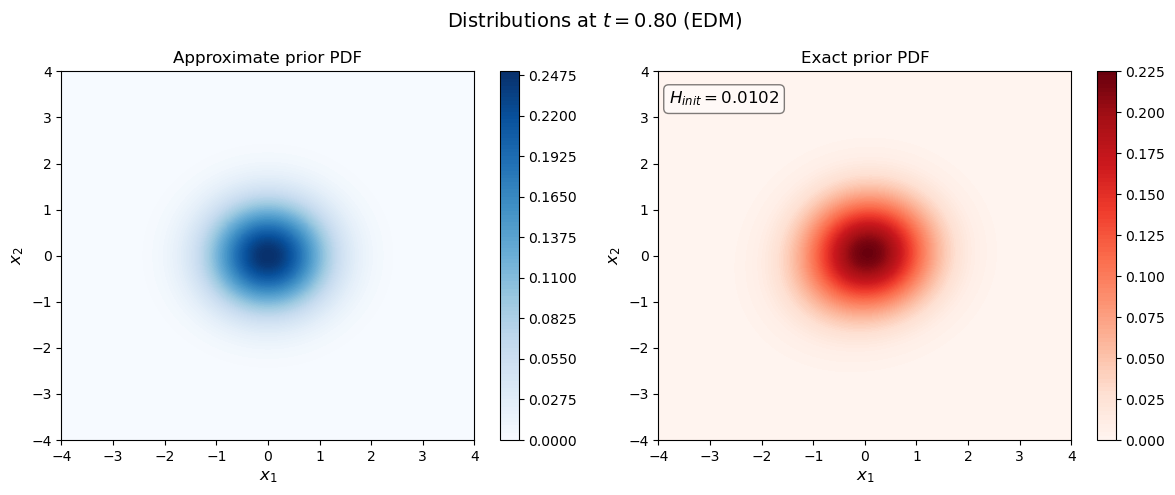

0.010188517160713673

In [22]:
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
xlim = 5*sigma
exact_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim, process=process,
                                                   fontsize=12, ndim=2, ngrid=100)
exact_initial_entropy

In [23]:
exact_prior = False

prior = 'approx_prior'
if exact_prior:
    exact_initial_entropy = 0
    prior = 'exact_prior'

In [24]:
# data parameters
m = torch.norm(points2[0] - points2[1])
print(m)
p = weights2[0]
print(p)
sigma_data = scale2

dim = 2
factor_c = None
# compute bound
integral, error = compute_integral(0, initial_time-tmin, initial_time, m, p, sigma_data)
decay= np.exp(-integral)
bound_gauss = decay * exact_initial_entropy
print(f'Initial entropy: {exact_initial_entropy:.7f}')
print(f'Bound: {bound_gauss:.7f}')

tensor(0.9899)
tensor(0.1000)
Initial entropy: 0.0101885
Bound: 0.0074127


NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): HeunIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Sample-based initial entropy = 0.01351


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


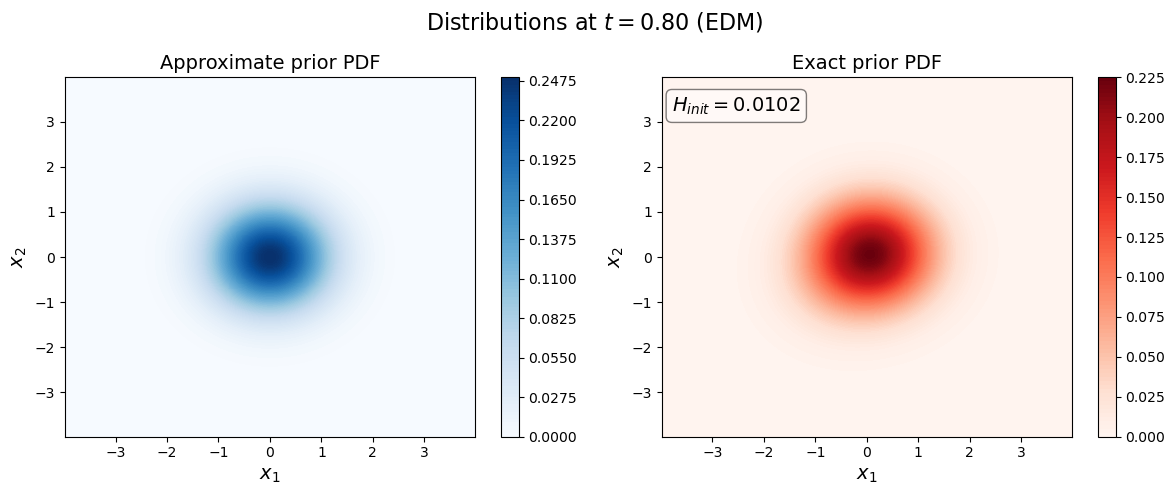

Exact initial entropy = 0.01019


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2596350072.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


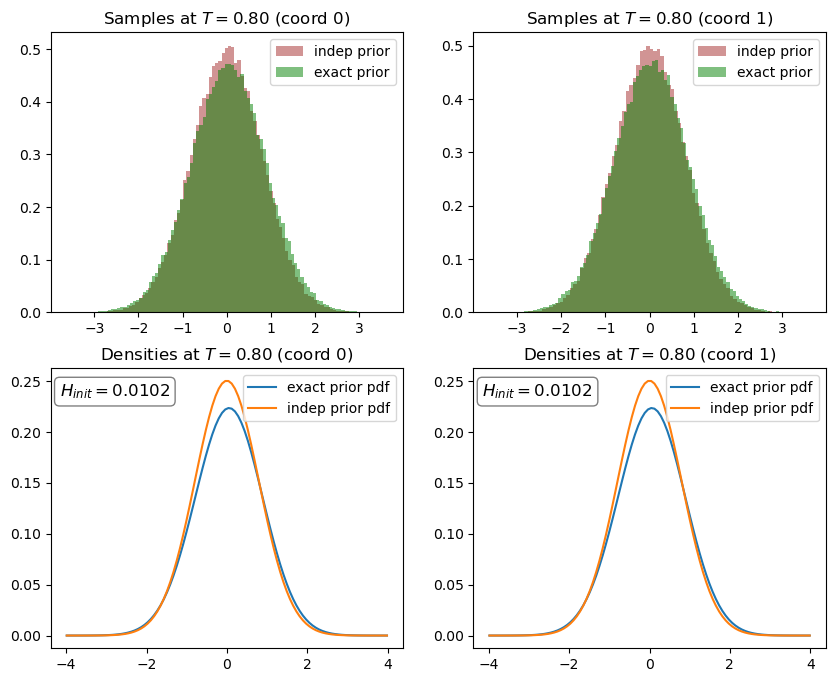

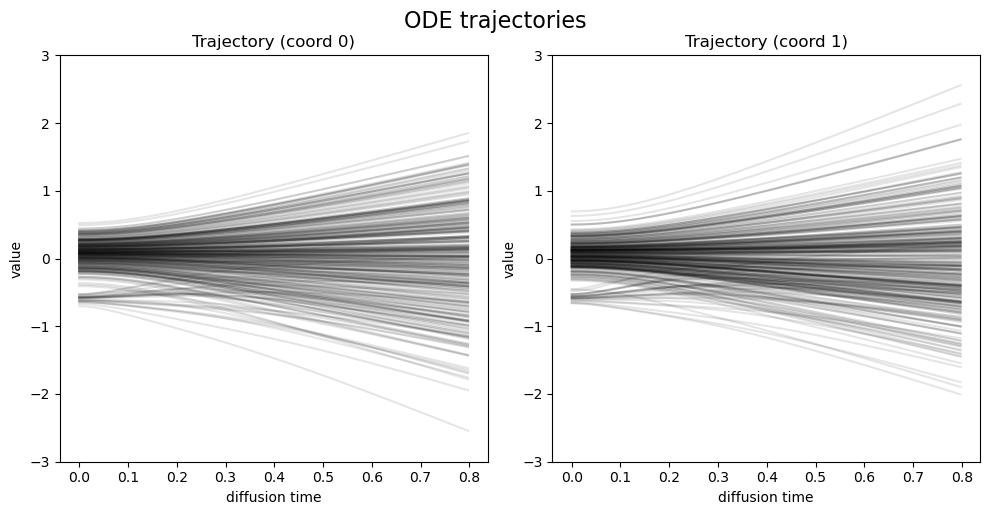

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\2d_gaussian2\ode-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.797-his-EDM


In [25]:
ode_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype, sample_type='ode',
                               noisescheduler=scheduler, scheduler_type = process, use_exact_prior=exact_prior)

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): EulerIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Sample-based initial entropy = 0.01400


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


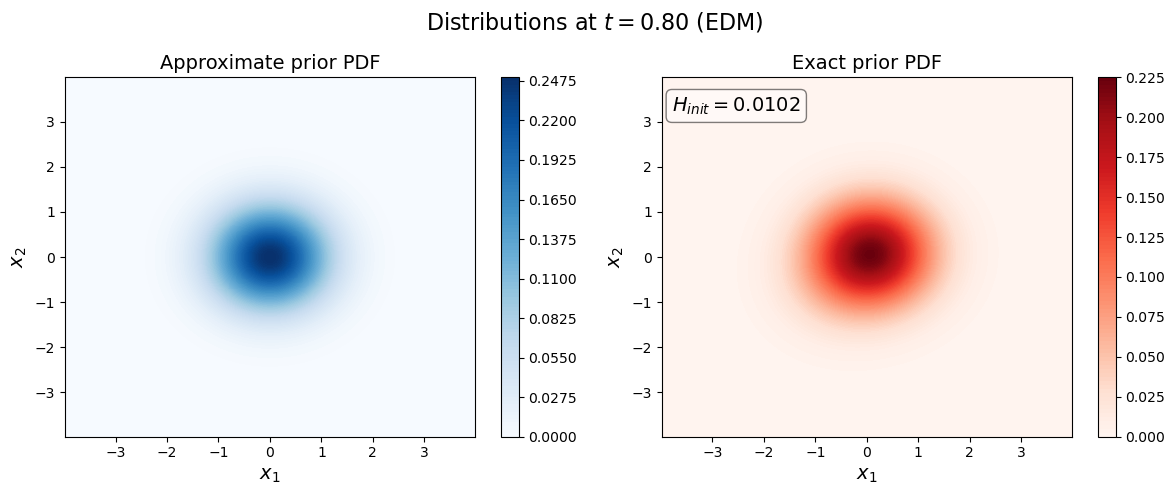

Exact initial entropy = 0.01019


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2596350072.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


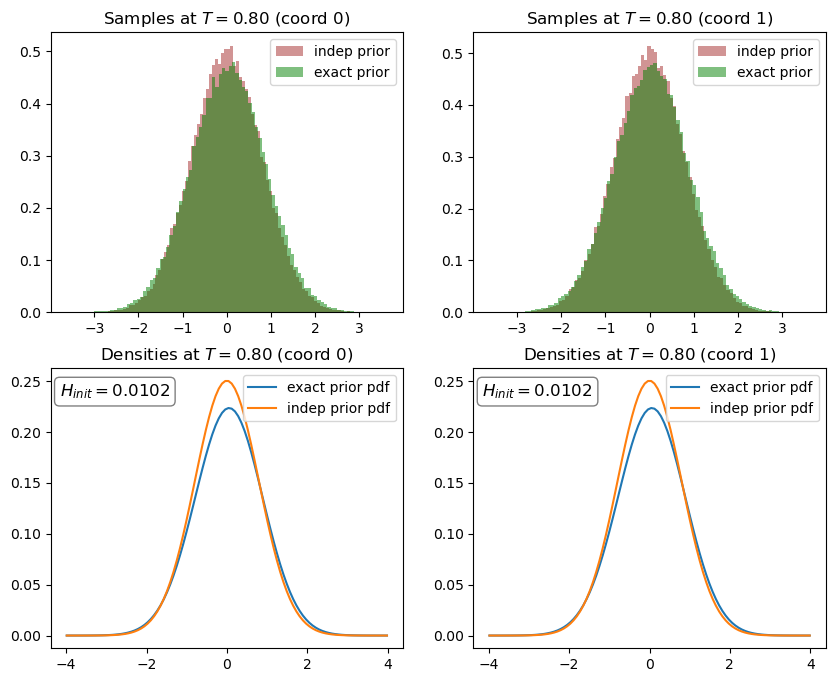

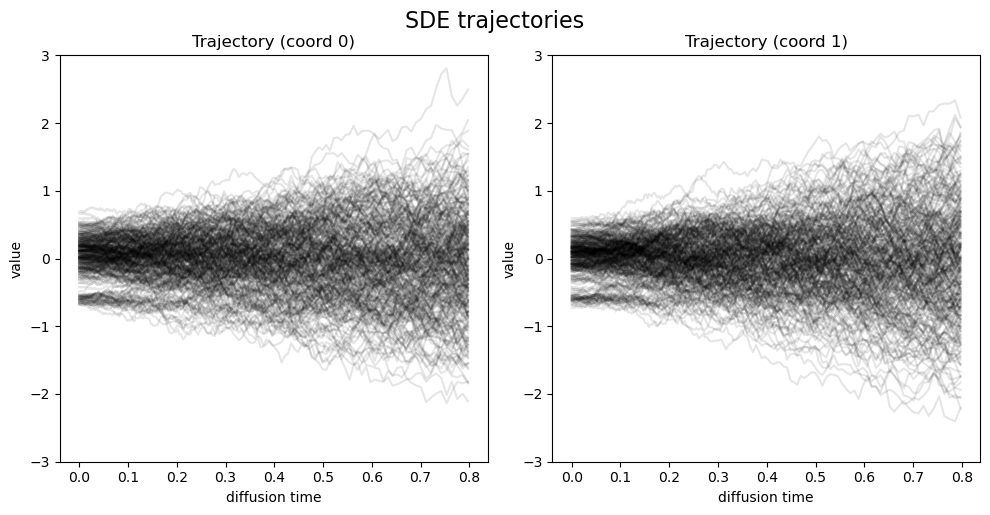

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\2d_gaussian2\sde-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.797-g=1-his-EDM


In [26]:
sde_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, datatype, sample_type='sde',
                               noisescheduler=scheduler, scheduler_type = process, use_exact_prior=exact_prior)

In [27]:
# # load data
# ode_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\ode-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.211-his-VP"
# sde_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\outputdata\bps\entropy_paper\gaussian2\sde-indep_prior-an-nsamples=1e+05-nsteps=500-T=0.211-g=1-his-VP"
# ode_history = torch.load(ode_path)
# sde_history = torch.load(sde_path)

In [39]:
ode_samples = ode_history[-1]
sde_samples = sde_history[-1]
# truncate samples at absolute value = 10
mask = torch.all(torch.abs(ode_samples) < 10, dim=1)
ode_samples = ode_samples[mask]
mask = torch.all(torch.abs(sde_samples) < 10, dim=1)
sde_samples = sde_samples[mask]
ode_samples.shape, sde_samples.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

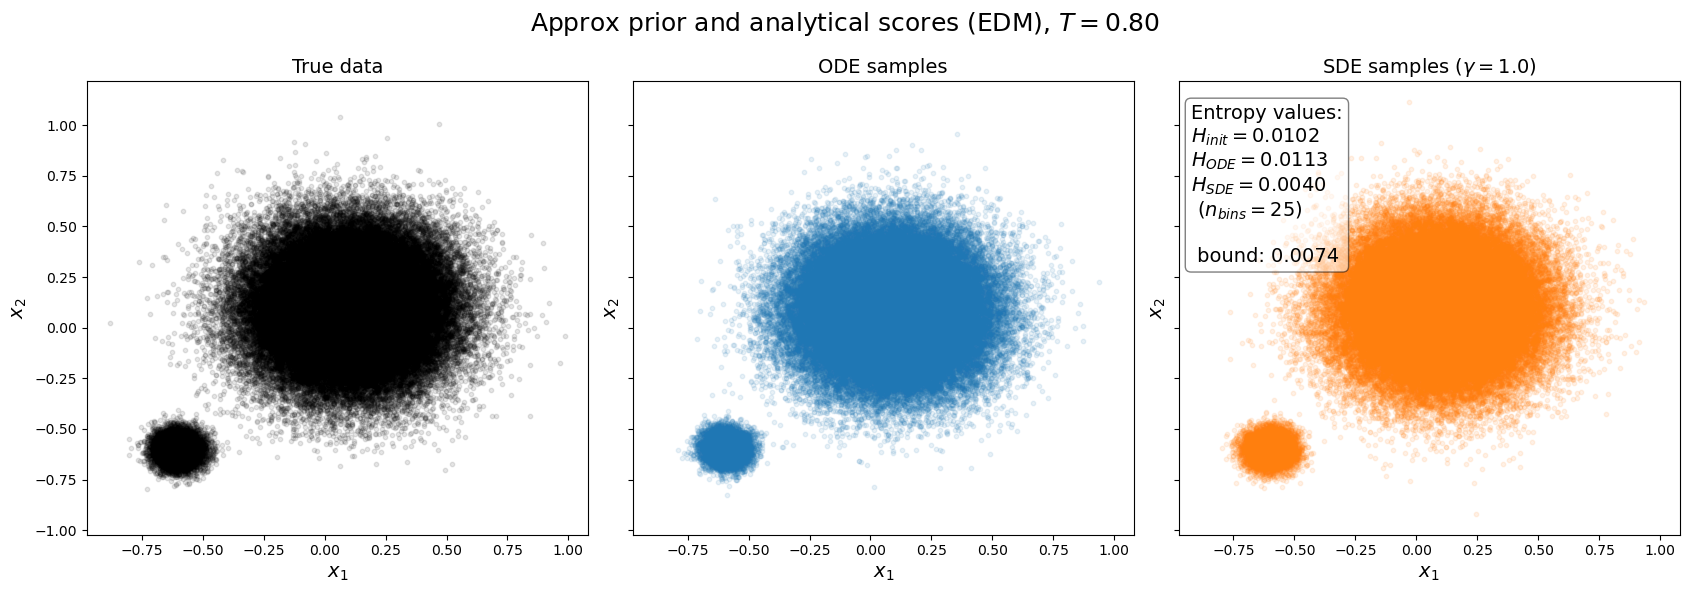

In [60]:
nbins = 25
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins, initial_entropy=exact_initial_entropy, bound=bound_gauss,
            title=f'Approx prior and analytical scores ({process.upper()})', figname=f'{prior}-analytic-{process}',
            fontsize=14)

In [31]:
history_steps = nsteps+1-initial_step
forw_sde_history = scheduler.propagate_forward(data, dataset.gradlogprob, nsteps, record_history=True, stochastic=True)
forw_sde_history = forw_sde_history.cpu()
forw_sde_his = forw_sde_history[:history_steps].squeeze(-1)
forw_sde_his = forw_sde_his.flip(0)
forw_sde_his.shape

torch.Size([286, 100000, 2])

In [51]:
forw_ode_history = scheduler.propagate_forward(data, dataset.gradlogprob, nsteps, record_history=True, stochastic=False)
forw_ode_history = forw_ode_history.cpu()
forw_ode_his = forw_ode_history[:history_steps].squeeze(-1)
forw_ode_his = forw_ode_his.flip(0)
forw_sde_his[-1] = data
forw_ode_his.shape

torch.Size([286, 100000, 2])

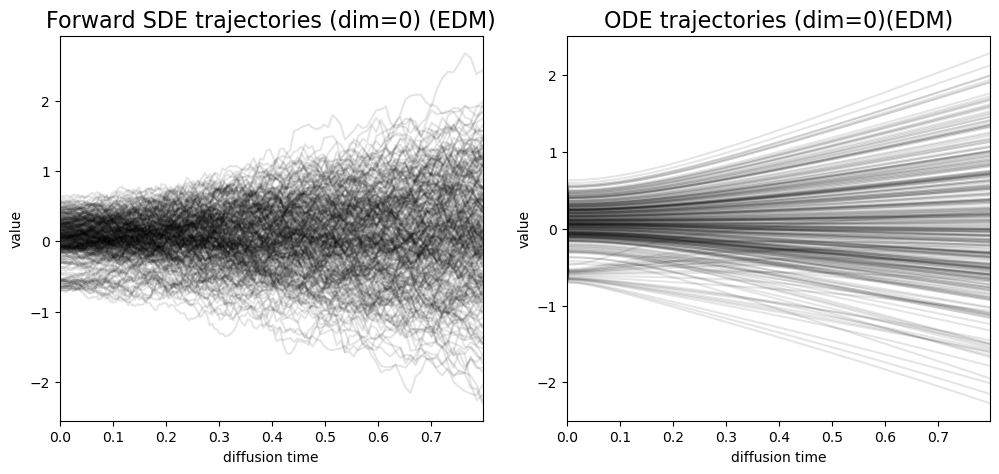

In [52]:
# plot forward trajectories
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
time2 = time[initial_step:]
nplot = 300
plot_dim = 0
for i in range(nplot):
    x_sde = forw_sde_his[:, i, plot_dim].squeeze()
    x_ode = forw_ode_his[:, i, plot_dim].squeeze()
    axs[0].plot(time2, x_sde, color='black', linestyle='-', alpha=0.1)
    axs[1].plot(time2, x_ode, color='black', linestyle='-', alpha=0.1)
axs[0].set_title(f'Forward SDE trajectories (dim={plot_dim}) ({process.upper()})', fontsize=16)
axs[1].set_title(f'ODE trajectories (dim={plot_dim})({process.upper()})', fontsize=16)
for ax in axs:
    # ax.set_ylim([-3, 3])
    ax.set_xlim([0, initial_time])
    ax.set_xlabel("diffusion time")
    ax.set_ylabel("value")

In [53]:
# # save forward sde history
# gaussianpath = pathlib.Path('C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/outputdata/bps/entropy_paper/gaussian2')
# torch.save(forw_sde_his, gaussianpath / f'forw_sde_history-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.2f}-{process}')

# # load forward sde history
# forw_sde_his = torch.load(gaussianpath / f'forw_sde_history-nsamples={nsamples:.0e}-nsteps={nsteps}-T={initial_time:.2f}-{process}')

In [54]:
# generate bounds
time2 = time[initial_step:]
times = time2[0] - time2
bound_gauss_history = []
for t in times:
    integral, error = compute_integral(0, t, initial_time, m, p, sigma_data)
    decay = np.exp(-integral)
    bound_gauss = decay * exact_initial_entropy
    bound_gauss_history.append(bound_gauss)

C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2253309263.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = integrate.quad(integrand, t_initial, t_final, args=(initial_time, m, p, sigma_data))


In [61]:
nbins = 25
ode_entropies, sde_entropies = compute_entropy_evolution(ode_history, sde_history, forw_sde_his, time2, mean=True, nbins=nbins)

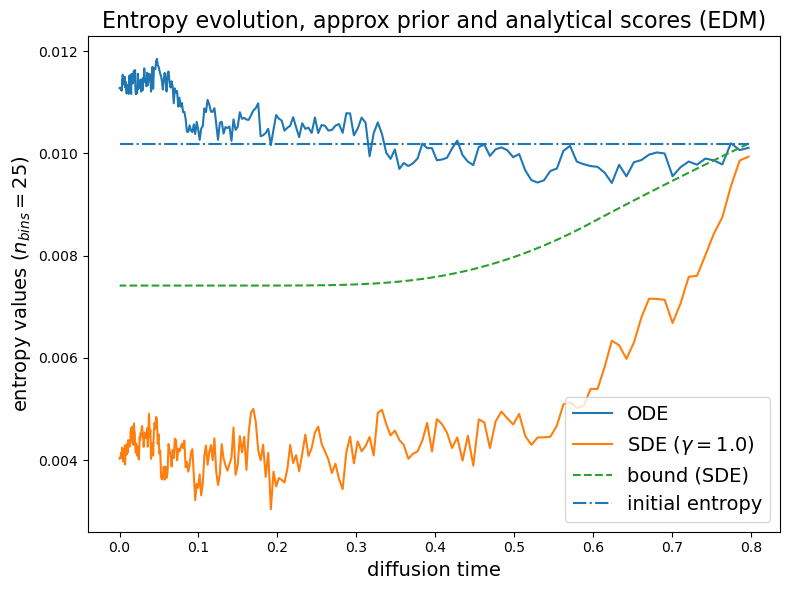

In [62]:
plot_entropy_evolution(ode_entropies, sde_entropies, time2, nsamples, gamma, initial_time, nsteps, datatype,
                       nbins=nbins, initial_entropy=exact_initial_entropy, bound_history=bound_gauss_history, exact_score=True,
                       title=f'Entropy evolution, approx prior and analytical scores ({process.upper()})', 
                       figname=f'entropy_evolution-{prior}-analytic-bound-{process}',
                       x_logscale=False, y_logscale=False)

Learned score functions

In [63]:
import lightning
import lightning.pytorch.callbacks as callbacks
import lightning.pytorch.loggers as pl_loggers

from diffsci.models import KarrasModule, KarrasModuleConfig

In [64]:
dataset = gaussian_dataset2

In [65]:
# data for training
batch_size = 16
train_size = int(nsamples*0.5)
test_size = int(nsamples*0.5)
num_workers=0
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# model

noise_log_mean = -2
config = KarrasModuleConfig.from_edm(prior_mean = noise_log_mean)
layers = [100, 100, 100]
model = diffsci.models.MLPUncond(2, layers, nonlinearity=torch.nn.SiLU(), dropout=0.1)
module = KarrasModule(model, config)

# training parameters
learning_rate = 4e-4
module.optimizer = torch.optim.AdamW(module.parameters(),
                                    lr=learning_rate,)
module.lr_scheduler = None
num_epochs = 15

In [66]:
# set trainer

savefolderstr = f"2d_mixt_gauss_norm-{layers}-lr={learning_rate}-bs={batch_size}-nsamples={nsamples}-n_lmean={noise_log_mean}"
MODELSPATH = 'C:/Users/bepsc/OneDrive/Documentos/GitHub/DiffSci/savedmodels/experimental'
savedir = os.path.join(MODELSPATH, savefolderstr)

checkpoint_callback = callbacks.ModelCheckpoint(
        monitor='valid_loss',
        dirpath=os.path.join(savedir, 'checkpoints'),
        filename='sample-{epoch:02d}-{valid_loss:.6f}',
        save_top_k=3,
        mode='min',
    )

tb_logger = pl_loggers.TensorBoardLogger(save_dir=savedir, name='logs')

trainer = lightning.Trainer(max_epochs=num_epochs,
                            logger=tb_logger,
                            callbacks=[checkpoint_callback],
                            fast_dev_run=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
# trainer.fit(model=module,
#             train_dataloaders=train_dataloader,
#             val_dataloaders=test_dataloader)

In [68]:
# load model (substitute by your checkpointpath)

checkpointpath = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\2d_mixt_gauss_norm-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000-n_lmean=-2\checkpoints\sample-epoch=12-valid_loss=0.344025.ckpt"
module = KarrasModule.load_from_checkpoint(model=model, config=config, checkpoint_path=checkpointpath)
datatype = 'gaussian2'

In [69]:
# Define parameters
process = 'edm'

if process == 'edm':
    scheduler = diffsci.models.EDMScheduler(sigma_max=10.0)
    initial_time=0.8
elif process == 'vp':
    scheduler = VPScheduler()
    initial_time=0.21
elif process == 've':
    scheduler = VEScheduler()
    initial_time=0.55
else:
    raise ValueError('Invalid process')

# initial_time = 2.0

initial_time_ = torch.tensor(initial_time)
nsteps = 500
gamma = 1
nsamples = 100000

initial_step = scheduler.step_from_time(t=initial_time_, n=nsteps)
time = scheduler.create_steps(nsteps+1)
initial_time = time[initial_step].item()
print(f'Initial step: {initial_step}')
print(f'Initial_time: {initial_time}')

Initial step: 215
Initial_time: 0.7972018122673035


In [70]:
# choose dataset
data_ = gaussian_samples2
data = data_.squeeze(-1)
dataset = gaussian_dataset2
datatype = 'gaussian2'

In [71]:
tmin = time[-1]
interval = None
# interval = [0.1, 1.0]

C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


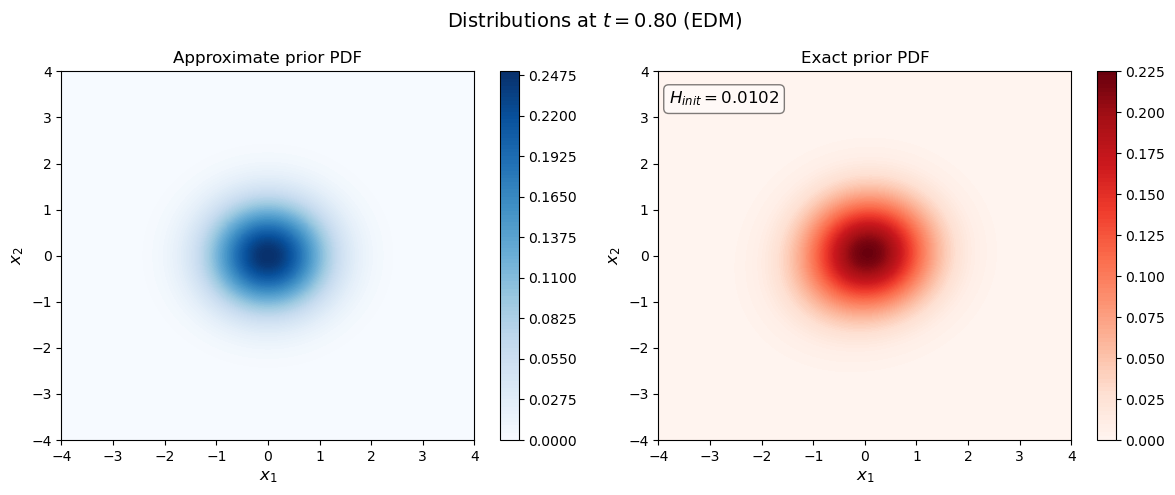

In [72]:
sigma = scheduler.scheduler_fns.noise_fn(initial_time_)
xlim = 5*sigma
exact_initial_entropy = analytical_initial_entropy(dataset, initial_time, scheduler=scheduler, plot=True, xlim=xlim, process=process,
                                                   fontsize=12, ndim=2, ngrid=100)

In [73]:
# Generate data for comparison
tmin = time[-2]
print(f'Final time: {tmin}')
sigma_min = scheduler.scheduler_fns.noise_fn(tmin)
scale_min = scheduler.scheduler_fns.scaling_fn(tmin)
noise = torch.randn_like(gaussian_samples2) * sigma_min * scale_min

diffused_gdata2 = scale_min * gaussian_samples2 + noise
diffused_data = diffused_gdata2

Final time: 0.0019999996293336153


In [74]:
# temporarily change gamma to 1
scheduler.langevin_const = 1

history_steps = nsteps+1-initial_step
forw_sde_history = scheduler.propagate_forward(diffused_data, dataset.gradlogprob, nsteps, record_history=True, stochastic=True)
forw_sde_history = forw_sde_history.cpu()
forw_sde_his = forw_sde_history[:history_steps].squeeze(-1)
forw_sde_his = forw_sde_his.flip(0)
forw_sde_his[-1] = data
forw_sde_his.shape

# unchange gamma
scheduler.langevin_const = gamma

Evaluate non-conservativity

In [78]:
from torch.func import jacrev, vmap

In [79]:
def antisym_ratio(score_fn, x, t, eps=1e-12):
    """
    Relative Frobenius norm of the antisymmetric part of ∇_x s.
    Returns a scalar in [0,1].
    """
    def s_of_x(x_single):
        return score_fn(x_single.unsqueeze(0), t.unsqueeze(0)).squeeze(0)

    J = jacrev(s_of_x)(x)           # d×d Jacobian wrt x
    antisym = 0.5 * (J - J.T)       # antisymmetric part
    return antisym.norm() / (J.norm() + eps)

# batched version (network is the constant in_dims arg)
batched_ratio = vmap(antisym_ratio, in_dims=(None, 0, 0))

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
module.to(device).eval()

n_points     = 1_000                 # per time-slice
n_t          = forw_sde_his.shape[0]
rel_asym_ts  = torch.empty(n_t)

for i in range(n_t):
    x = forw_sde_his[i, :n_points].to(device).requires_grad_()
    t_val = torch.full((n_points,), time[initial_step + i],
                       dtype=x.dtype, device=device)

    rel_asym_ts[i] = batched_ratio(module.get_score, x, t_val).mean().cpu()

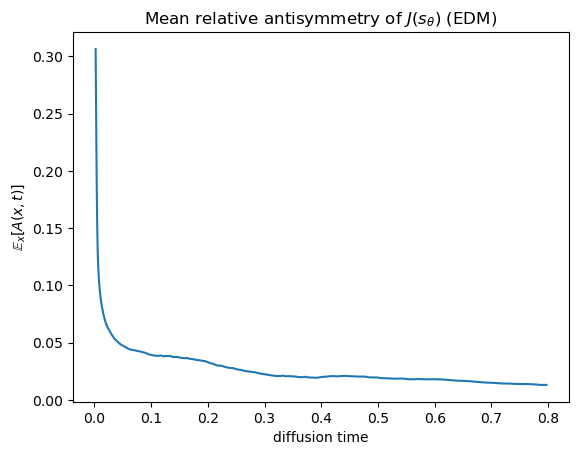

In [81]:
t_grid = time[initial_step : initial_step + n_t].cpu()

plt.plot(t_grid, rel_asym_ts.detach())
plt.xlabel("diffusion time")
plt.ylabel(r'$\mathbb{E}_x[A(x, t)]$')
plt.title(f"Mean relative antisymmetry of $J(s_{{\\theta}})$ ({process.upper()})")
plt.show()

Generate samples

In [82]:
exact_prior = True

prior = 'approx_prior'
if exact_prior:
    exact_initial_entropy = 0
    prior = 'exact_prior'

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): HeunIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
)
Sample-based initial entropy = 0.01507


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


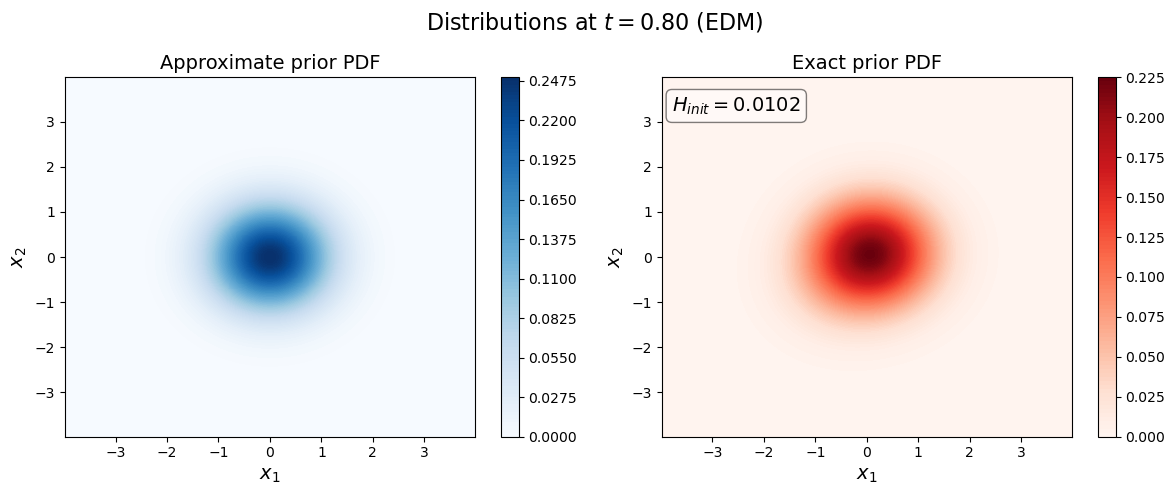

Exact initial entropy = 0.01019


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2596350072.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


Sampling with learned scores, device:  cuda:0


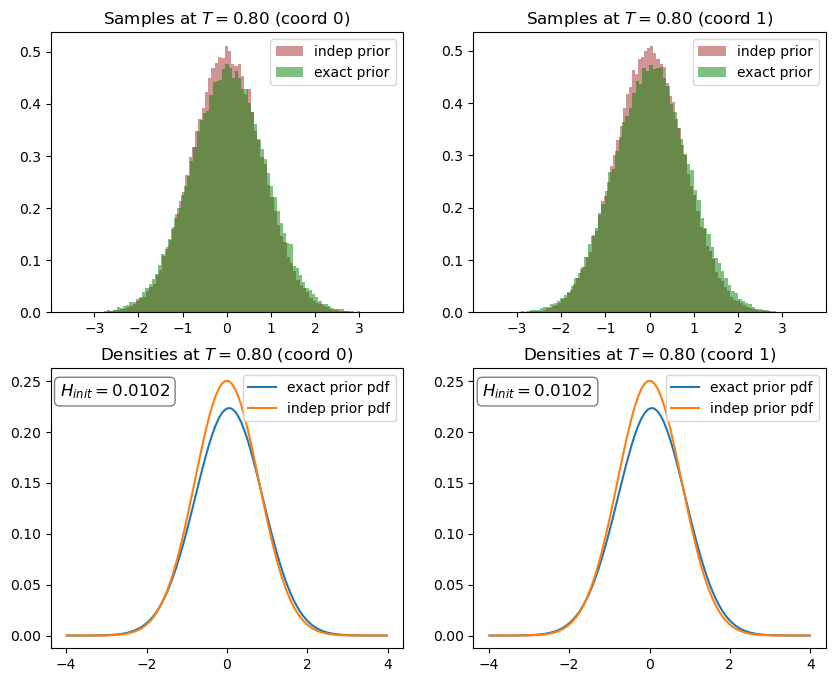

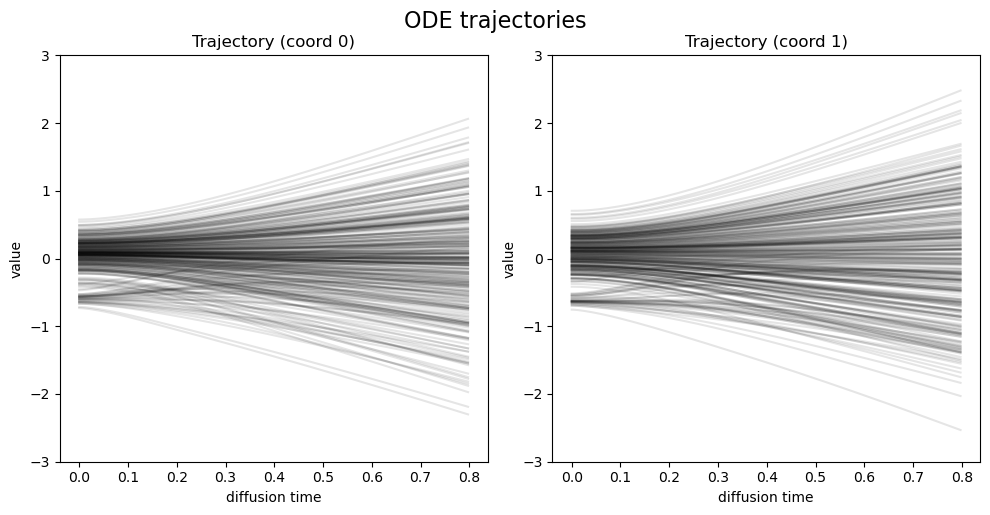

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\2d_mixt_gauss_norm-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000-n_lmean=-2\saved_samples\ode-exact_prior-tr-nsamples=1e+05-nsteps=500-T=0.797-his-EDM


In [83]:
ode_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, module=module, sample_type='ode',
                 checkpoint=checkpointpath, datatype=datatype, interval=interval, use_exact_prior=exact_prior,
                 return_history=True, noisescheduler=scheduler, scheduler_type=process)

NoiseScheduler: EDMScheduler(
  (scheduler_fns): EDMSchedulingFunctions()
  (_integrator): EulerIntegrator()
  (stochastic_integrator): EulerMaruyamaIntegrator()
  (_temporary_integrator): None
)
Sample-based initial entropy = 0.01367


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\1710439397.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


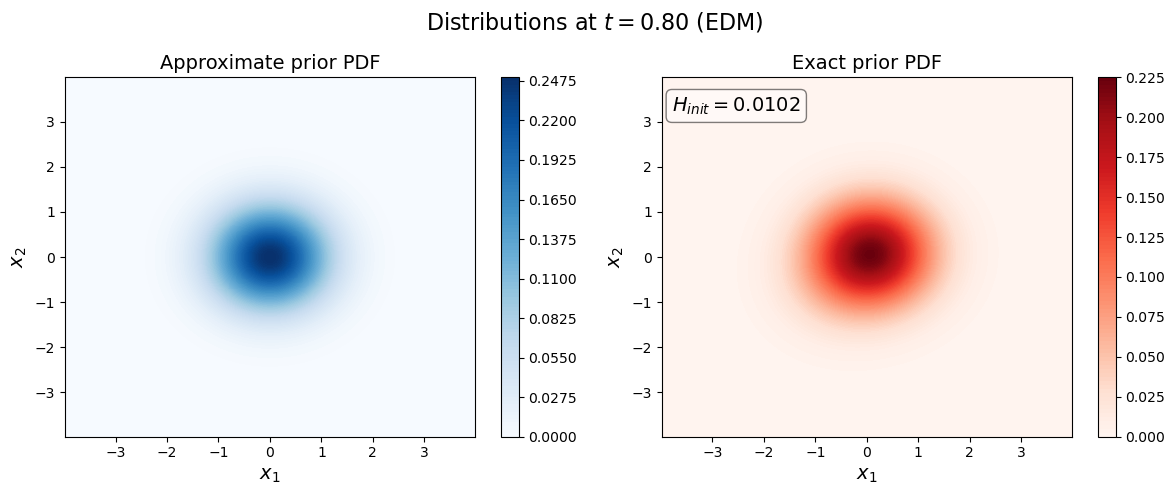

Exact initial entropy = 0.01019
Sampling with learned scores, device:  cuda:0


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2596350072.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(sigma * scale)


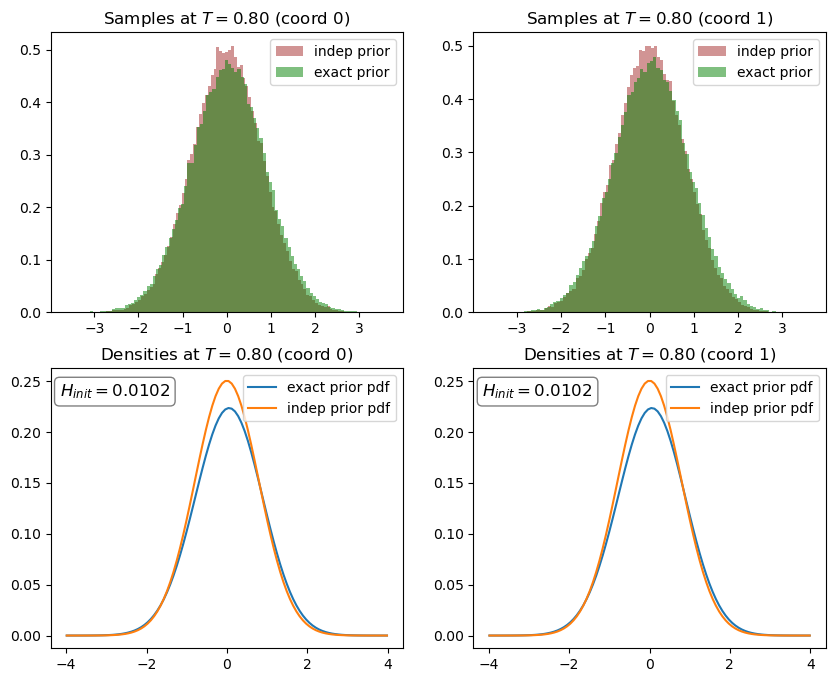

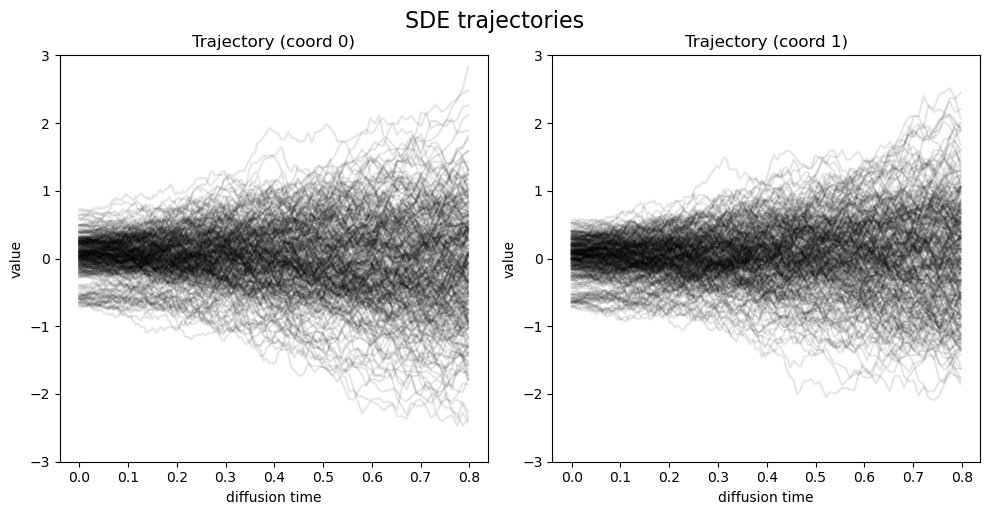

Saving samples to C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\2d_mixt_gauss_norm-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000-n_lmean=-2\saved_samples\sde-exact_prior-tr-nsamples=1e+05-nsteps=500-T=0.797-g=1-his-EDM


In [84]:
sde_history = generate_samples(initial_step, gamma, nsteps, nsamples, dataset, module=module, sample_type='sde',
                 checkpoint=checkpointpath, datatype=datatype, interval=interval, use_exact_prior=exact_prior,
                 return_history=True, noisescheduler=scheduler, scheduler_type=process)

In [85]:
# # load samples

# ode_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\2d_mixt_gauss_norm-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000-n_lmean=-2\saved_samples\ode-exact_prior-tr-nsamples=1e+05-nsteps=500-T=0.797-his-EDM"
# sde_path = r"C:\Users\bepsc\OneDrive\Documentos\GitHub\DiffSci\savedmodels\experimental\2d_mixt_gauss_norm-[100, 100, 100]-lr=0.0004-bs=16-nsamples=100000-n_lmean=-2\saved_samples\sde-exact_prior-tr-nsamples=1e+05-nsteps=500-T=0.797-g=1-his-EDM"

# sde_history = torch.load(sde_path)
# ode_history = torch.load(ode_path)

In [86]:
ode_samples = ode_history[-1]
sde_samples = sde_history[-1]

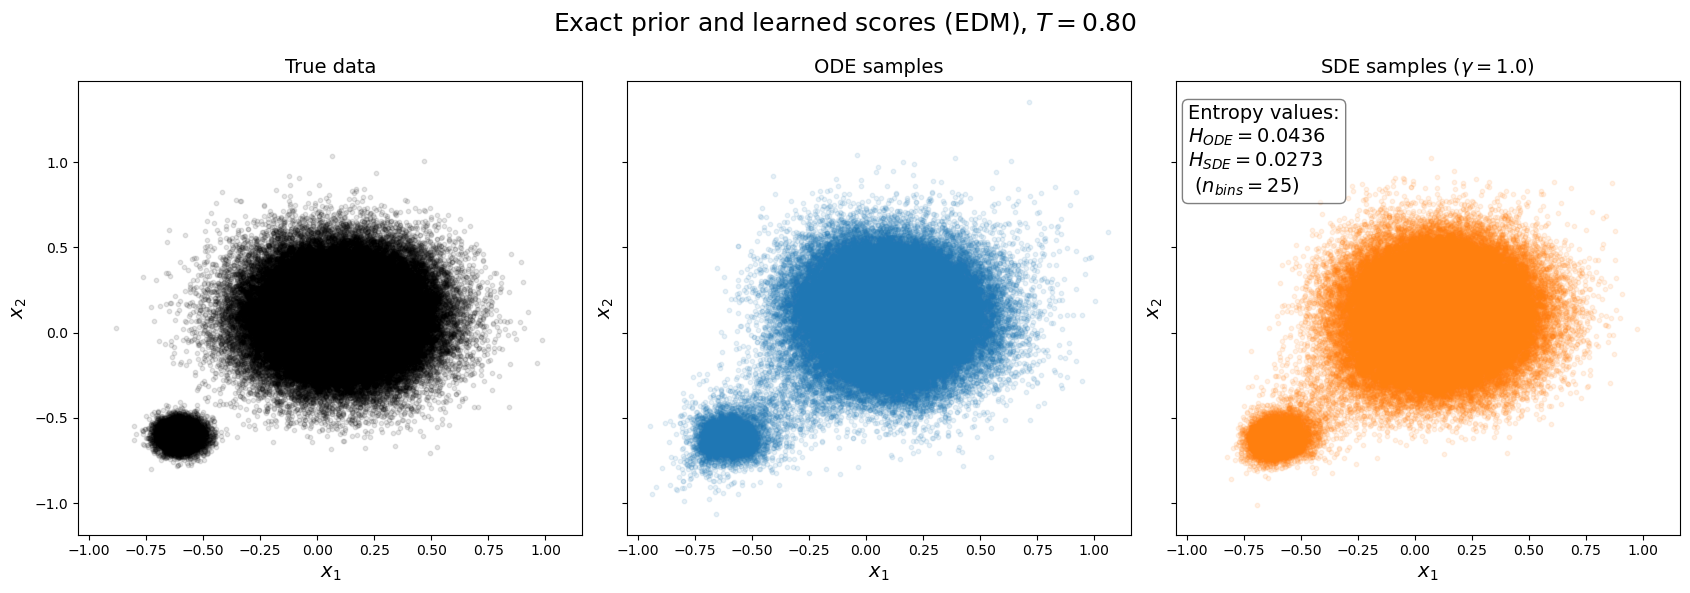

In [87]:
nbins = 25
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins,
            initial_entropy=exact_initial_entropy,
            title=f'Exact prior and learned scores ({process.upper()})', figname=f'{prior}-learned-silu-{process}-nobound')

In [88]:
# compute theorectical bound for the SDE with approximated scores

def g_squared(t, process):
    if process == 'edm':
        g2 = 2*t
    elif process == 'vp':
        beta_min = 0.1
        beta_d = 19.9
        g2 = beta_d * t + beta_min
    elif process == 've':
        g2 = 1
    return g2

def compute_integral1_discrete(step_initial, step_final, d_values):
    result = 0
    for step in range(step_initial, step_final):
        t = time[step]
        delta = d_values[step - initial_step] * gamma
        if datatype == 'gaussian':
            const = c_gauss(t, m, p, sigma_data)
        elif datatype == 'gaussian2':
            const = c_gauss2(t, m, p, sigma_data)
        if const == float('inf'):
            inv_C = 0
        else:
            inv_C = 1/const
        result += inv_C * g_squared(t, process) * (gamma - delta) * (time[step] - time[step+1])
    return result


def epsilon_norm(step, sde_history, interp_fn, datasize = 2000):
    x = sde_history[step-initial_step, :datasize,].cpu()
    t = time[step]
    sigma = scheduler.scheduler_fns.noise_fn(t * torch.ones(x.shape[0]))
    x_ = x.to(module.device)
    sigma_ = sigma.to(x_)
    s = scheduler.scheduler_fns.scaling_fn(t)
    score = module.get_score(x_/s, sigma_)
    analytic_score = dataset.gradlogprob(x, sigma).to(score)
    if interp_fn is not None:
        score_dist = torch.mean((interp_fn(t)*(score - analytic_score))**2)
    else:
        score_dist = torch.mean(torch.sum((score - analytic_score)**2, dim=-1))
    return score_dist.detach().cpu().numpy()


def compute_integral2_discrete(initial_step, step_final, tmin, d, sde_history, interp_fn):
    result = 0
    epsilon_ = []
    for step in range(initial_step, step_final):
        t = time[step]
        rev_t = initial_time - t
        if isinstance(d, list):
            integral1 = compute_integral1_discrete(step, step_final, d)
            delta = d[step - initial_step] * gamma
        else:
            raise ValueError('d must be a list of values for each step')
        weight = 1/8 * 1/delta * g_squared(t, process) * (1 + gamma)**2 * np.exp(-integral1)
        epsilon = epsilon_norm(step, sde_history, interp_fn)
        epsilon_.append(epsilon)
        result += weight * epsilon * (time[step] - time[step+1])
    return result, epsilon_

def compute_bound(initial_entropy, d, tmin, history, step_final=nsteps, interp_fn=None):
    if isinstance(d, list):
        integral1 = compute_integral1_discrete(initial_step, step_final, d)
    else:
        raise ValueError('d must be a list of values for each step')
    integral2, score_error = compute_integral2_discrete(initial_step, step_final, tmin, d, history, interp_fn)
    bound = np.exp(-integral1) * initial_entropy + integral2
    return bound, score_error

In [89]:
# compute bound
m = torch.norm(points2[0] - points2[1])
p = weights2[0]
sigma_data = scale2
dim = 2

factor_c = None
bound_values = []
d_values = np.linspace(0, 1, 10)
for d in d_values:
    d_val = [d]*len(sde_history)
    bound, score_error = compute_bound(exact_initial_entropy, d_val, tmin, sde_history)
    bound_values.append(bound)

C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2253309263.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2253309263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\968904965.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  weight = 1/8 * 1/delta * g_squared(t, process) * (1 + gamma)**2 * np.exp(-integral1)


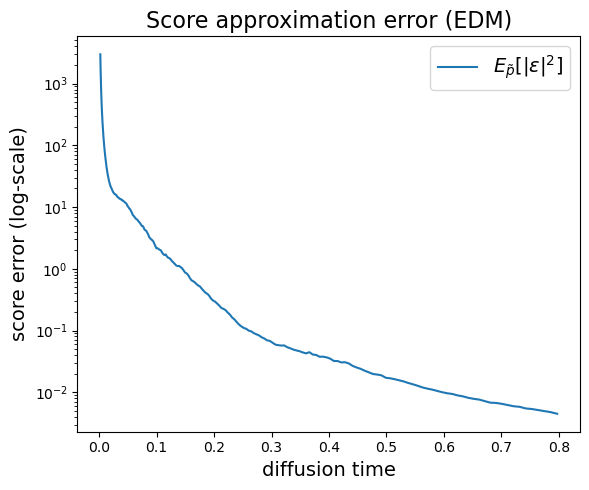

In [90]:
# plot score error
fontsize = 14
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
time_plot = time[initial_step:-1].squeeze(-1)
ax.plot(time_plot, score_error, label='$E_{\~p}[|\epsilon|^2]$')
ax.set_yscale('log')
ax.set_title(f'Score approximation error ({process.upper()})', fontsize=fontsize+2)
ax.set_xlabel('diffusion time',fontsize=fontsize)
ax.set_ylabel('score error (log-scale)', fontsize=fontsize)
# ax.set_ylabel('score error')
ax.legend(fontsize=fontsize)
plt.tight_layout()

In [91]:
# compute entropies
ode_entropy, sde_entropy = approx_entropy(ode_samples, sde_samples, data, nbins=nbins)

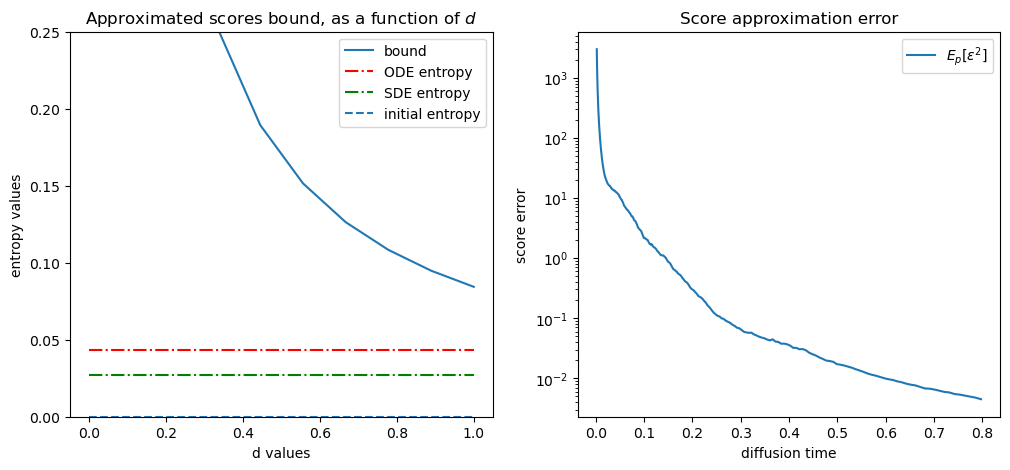

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot approximated scores bound as a function of delta
axs[0].plot(d_values, bound_values, label='bound')
axs[0].hlines(ode_entropy, d_values[0], d_values[-1], label='ODE entropy', linestyle='-.', color='red')
axs[0].hlines(sde_entropy, d_values[0], d_values[-1], label='SDE entropy', linestyle='-.', color='green')
axs[0].hlines(exact_initial_entropy, d_values[0], d_values[-1], label='initial entropy', linestyle='--')
axs[0].set_ylim(0, 0.25)
axs[0].set_xlabel('d values')
axs[0].set_ylabel('entropy values')
axs[0].legend()
axs[0].set_title('Approximated scores bound, as a function of $d$')

# plot score error
time_plot = time[initial_step:-1].squeeze(-1)
axs[1].plot(time_plot, score_error, label='$E_{p}[\epsilon^2]$')
axs[1].set_yscale('log')
axs[1].set_title('Score approximation error')
axs[1].set_xlabel('diffusion time')
axs[1].set_ylabel('score error')
axs[1].legend()

In [95]:
time2 = time[initial_step:]
ode_entropies, sde_entropies = compute_entropy_evolution(ode_history, sde_history, forw_sde_his, time2, nbins=nbins)

In [96]:
d_val = [1]*len(time2)
bound1d_history = []
for step_final in range(initial_step, nsteps):
    print(f'step={step_final}')
    bound1d, _ = compute_bound(exact_initial_entropy, d_val, tmin, sde_history, step_final=step_final)
    bound1d_history.append(bound1d)
bound1d_history2 = bound1d_history.copy()
bound1d_history2.append(bound1d_history[-1])

step=215
step=216
step=217
step=218
step=219
step=220
step=221
step=222
step=223


C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2253309263.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = scheduler.scheduler_fns.noise_fn(torch.tensor(t))
C:\Users\bepsc\AppData\Local\Temp\ipykernel_16756\2253309263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scheduler.scheduler_fns.scaling_fn(torch.tensor(t))


step=224
step=225
step=226
step=227
step=228
step=229
step=230
step=231
step=232
step=233
step=234
step=235
step=236
step=237
step=238
step=239
step=240
step=241
step=242
step=243
step=244
step=245
step=246
step=247
step=248
step=249
step=250
step=251
step=252
step=253
step=254
step=255
step=256
step=257
step=258
step=259
step=260
step=261
step=262
step=263
step=264
step=265
step=266
step=267
step=268
step=269
step=270
step=271
step=272
step=273
step=274
step=275
step=276
step=277
step=278
step=279
step=280
step=281
step=282
step=283
step=284
step=285
step=286
step=287
step=288
step=289
step=290
step=291
step=292
step=293
step=294
step=295
step=296
step=297
step=298
step=299
step=300
step=301
step=302
step=303
step=304
step=305
step=306
step=307
step=308
step=309
step=310
step=311
step=312
step=313
step=314
step=315
step=316
step=317
step=318
step=319
step=320
step=321
step=322
step=323
step=324
step=325
step=326
step=327
step=328
step=329
step=330
step=331
step=332
step=333
step=334
s

In [97]:
# # save bound history
# path = os.path.dirname(checkpointpath)
# path = os.path.dirname(path)
# path = os.path.join(path, 'saved_samples')
# torch.save(bound1d_history2, os.path.join(path, f'bound1d_history-{prior}-{process}-g={gamma}'))

In [98]:
ode_entropies, sde_entropies = compute_entropy_evolution(ode_history, sde_history, forw_sde_his, time2, nbins=nbins)

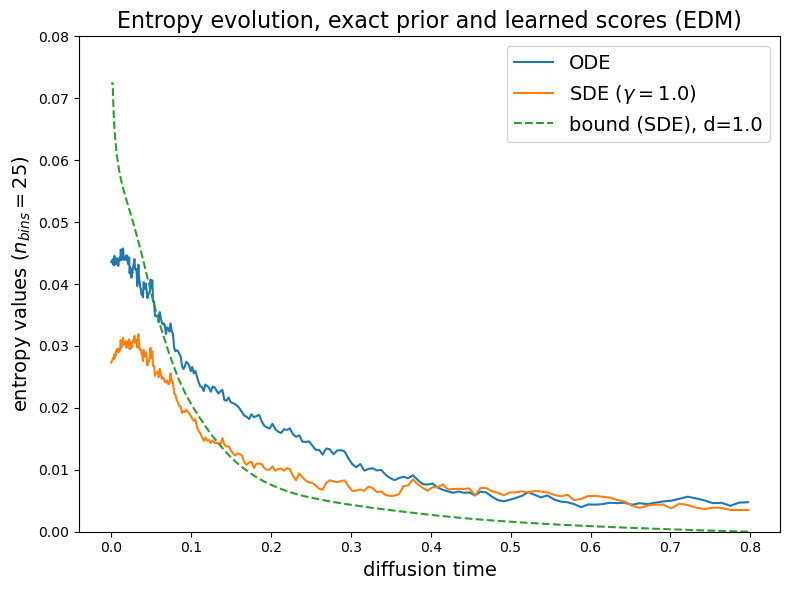

In [103]:
plot_entropy_evolution(ode_entropies, sde_entropies, time2, nsamples, gamma, initial_time, nsteps, datatype,
                       nbins=nbins,
                       bound_history=[[bound1d_history2, 1.0]],
                       initial_entropy=exact_initial_entropy,
                       title=f'Entropy evolution, exact prior and learned scores ({process.upper()})',
                       figname=f'entropy_evolution-{prior}-learned-silu5-{process}-delta1d',
                       x_logscale=False, y_logscale=False, ylim=0.08)

In [100]:
bound1d = bound1d_history2[-1]

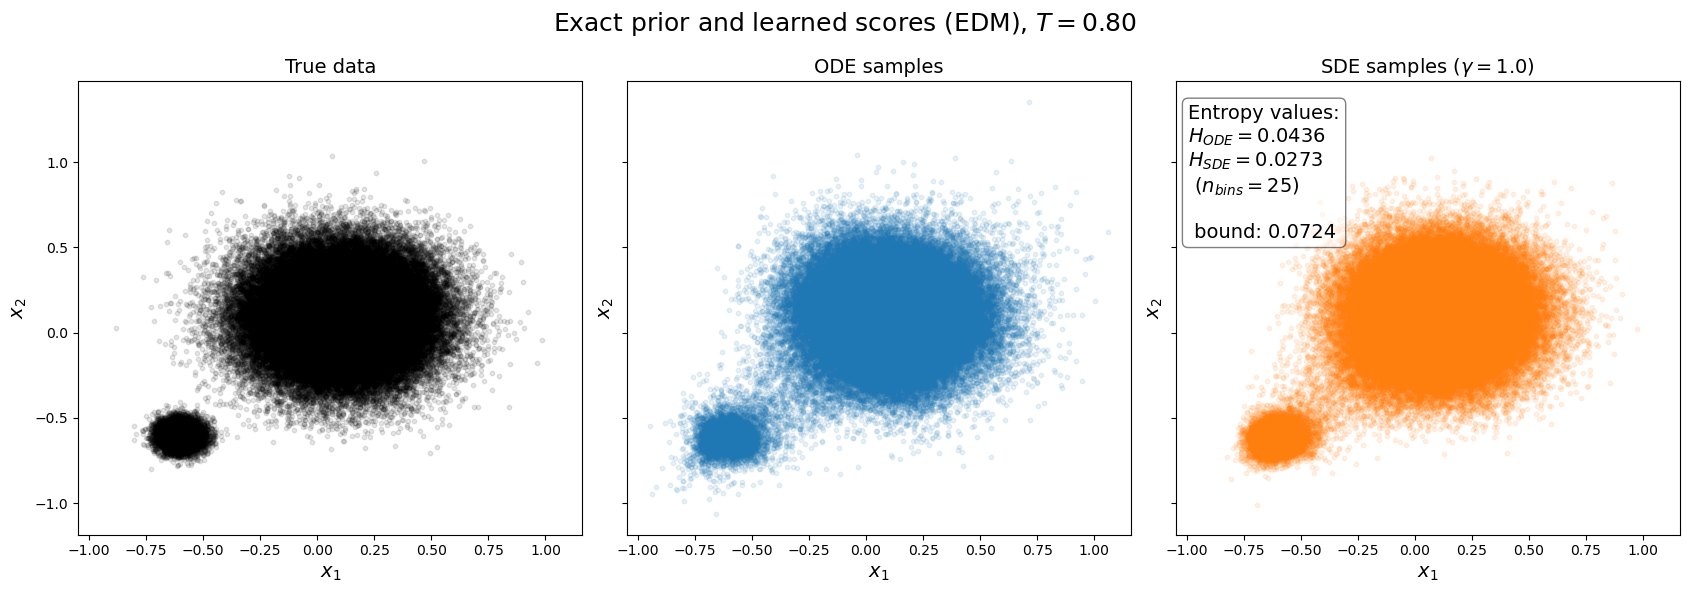

In [101]:
plot_figure(ode_samples, sde_samples, data, nsamples, nsteps, gamma, initial_time, datatype = datatype,
            nbins=nbins, bound=bound1d,
            initial_entropy=exact_initial_entropy,
            title=f'Exact prior and learned scores ({process.upper()})', figname=f'{prior}-learned-silu-{process}')